In [1]:
!pip install keras-tcn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


Loaded IMFs from the file.
Saved plot to /Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/dataset/CEEMDAN_1 in high quality.


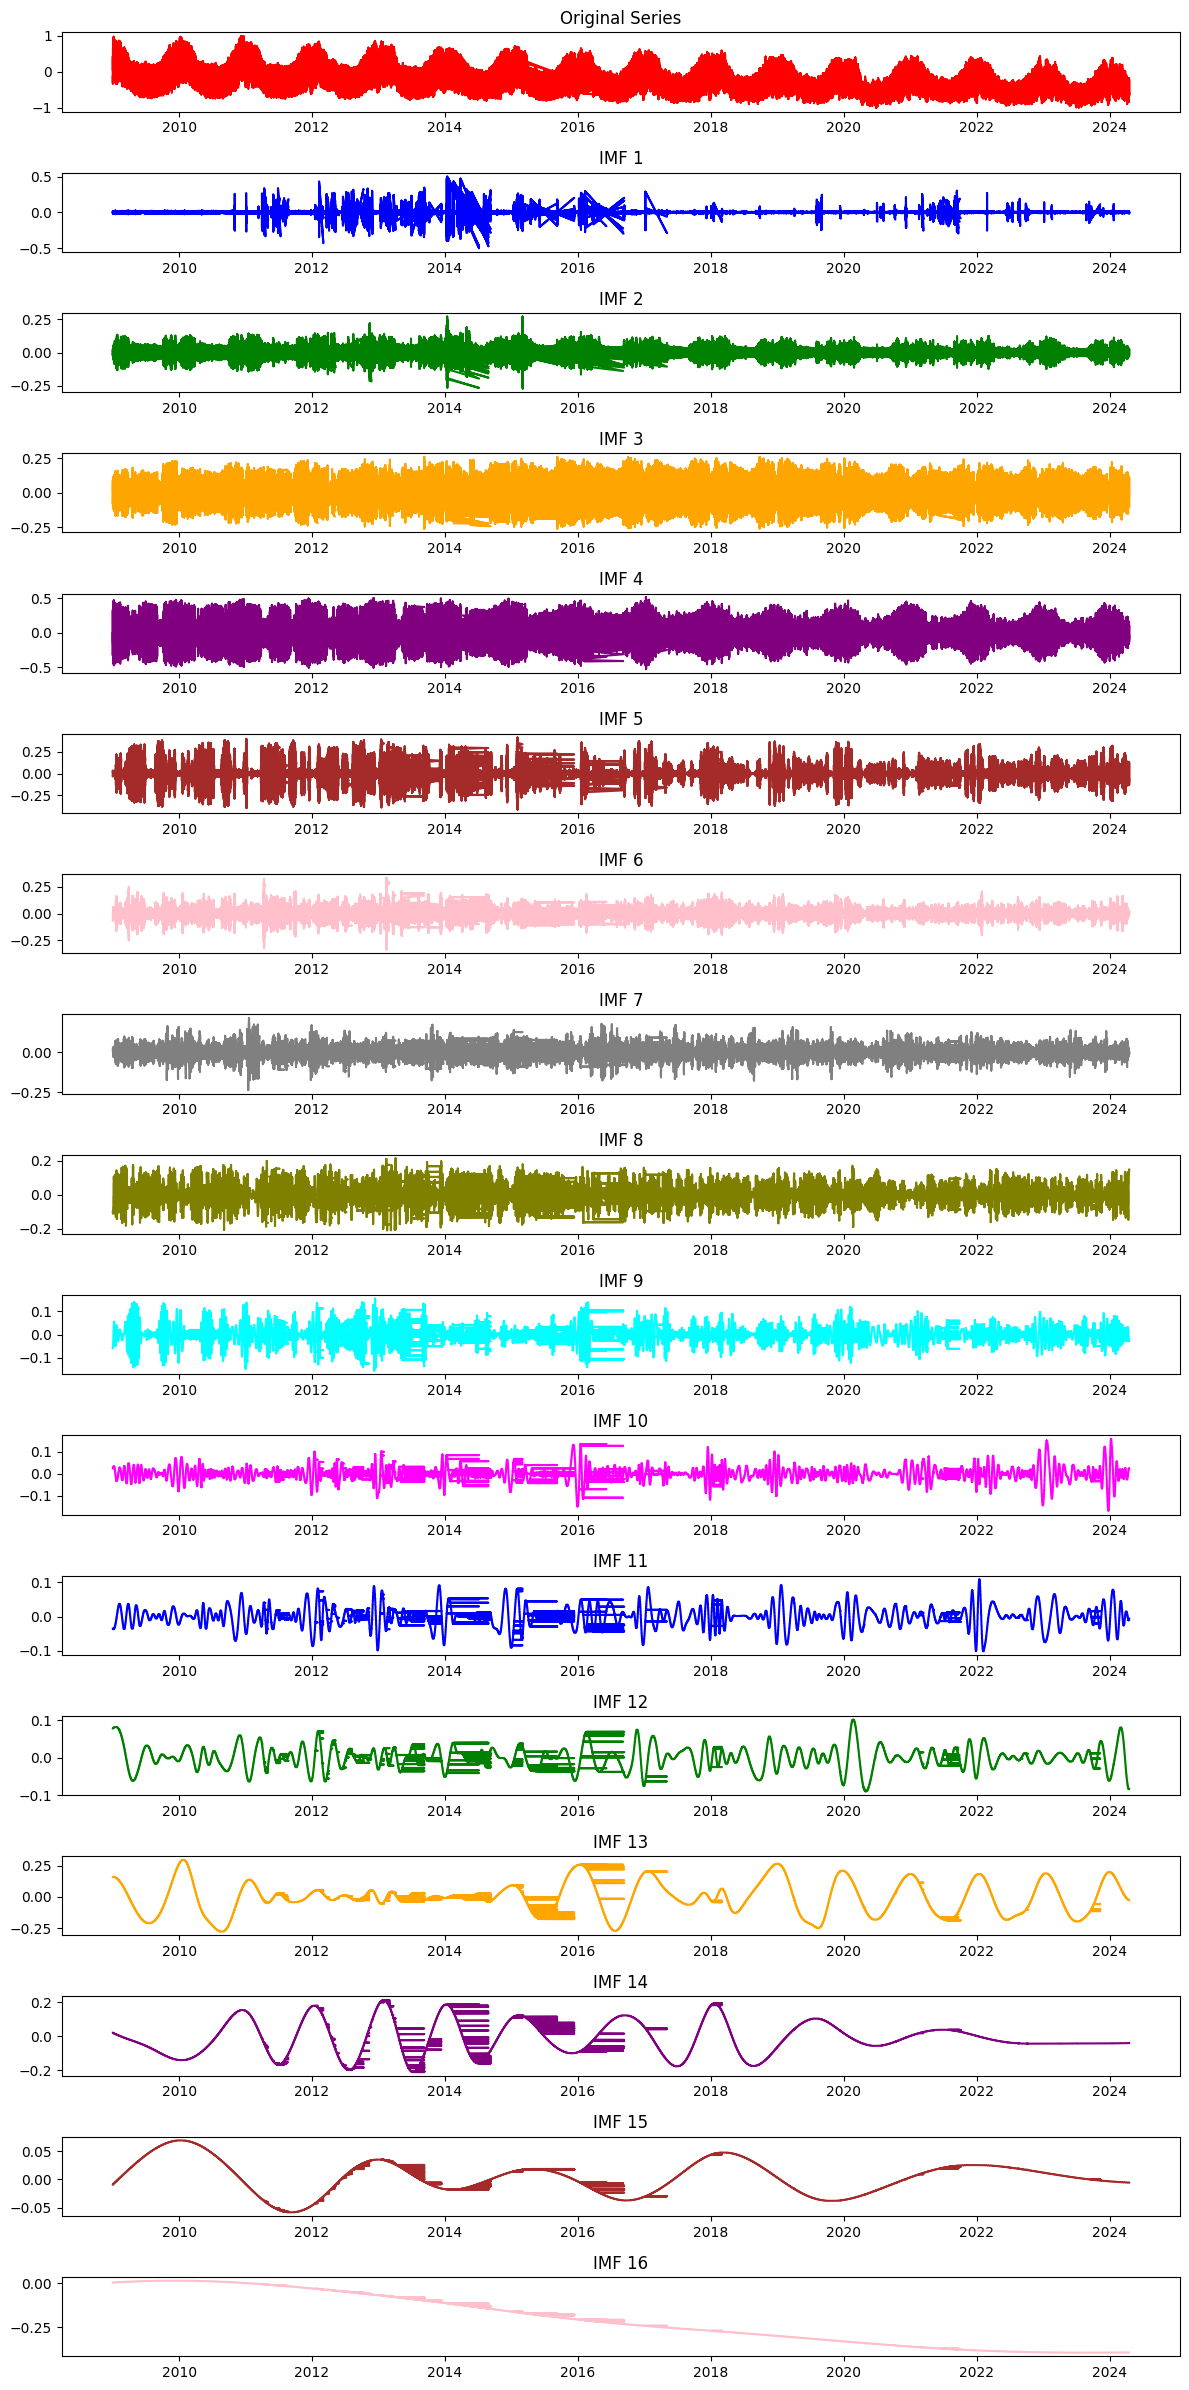

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler

# Define the dataset path and IMFs file path
dataset_path = '/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/dataset/historic_demand_2009_2024.csv'
imfs_path = os.path.join(os.path.dirname(dataset_path), 'imfs.npy')

# Load and prepare the dataset
df = pd.read_csv(dataset_path)
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df.set_index('settlement_date', inplace=True)

# Extract the 'nd' column
nd_series = df['nd'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_nd_series = scaler.fit_transform(nd_series.reshape(-1, 1)).flatten()

# Check if IMFs already exist
if os.path.exists(imfs_path):
    # Load the IMFs from the file
    IMFs = np.load(imfs_path)
    print("Loaded IMFs from the file.")
else:
    # Initialize CEEMDAN
    ceemdan = CEEMDAN()

    # Time the decomposition process
    import time
    start_time = time.time()
    IMFs = ceemdan.ceemdan(scaled_nd_series)
    end_time = time.time()

    # Print the time taken
    print(f"Time taken for CEEMDAN decomposition: {end_time - start_time:.2f} seconds")

    # Save IMFs for future use
    np.save(imfs_path, IMFs)
    print("Saved IMFs to the file.")

# Plot the original series and selected IMFs
plt.figure(figsize=(12, 24))  # Increased height to 24 inches

# Plot the original series
plt.subplot(len(IMFs) + 1, 1, 1)
plt.plot(df.index, scaled_nd_series, 'r')
plt.title('Original Series')

# Define a list of colors for IMFs
colors = ['b', 'g', 'orange', 'purple', 'brown', 'pink', 'grey', 'olive', 'cyan', 'magenta']

# Plot each selected IMF
for i, imf in enumerate(IMFs):
    plt.subplot(len(IMFs) + 1, 1, i + 2)
    plt.plot(df.index, imf, colors[i % len(colors)])
    plt.title(f'IMF {i+1}')

plt.tight_layout()

# Save the figure in high quality
high_quality_path = os.path.join(os.path.dirname(dataset_path), 'CEEMDAN_1')
plt.savefig(high_quality_path, dpi=300)
print(f"Saved plot to {high_quality_path} in high quality.")

plt.show()

In [14]:
print("sakib")

sakib


Epoch 1/5
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 168s 50ms/step - loss: 0.0330 - val_loss: 0.0036
Epoch 2/5
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 162s 48ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 3/5
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 160s 48ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 4/5
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 145s 43ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 5/5
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 156s 47ms/step - loss: 0.0022 - val_loss: 0.0010
6702/6702 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
Train MAE: 442.3634971244906, Train RMSE: 710.2505804075647, Train R2: 0.9917101266721561
Test MAE: 442.3224337585504, Test RMSE: 723.8594354133745, Test R2: 0.9913722661431558


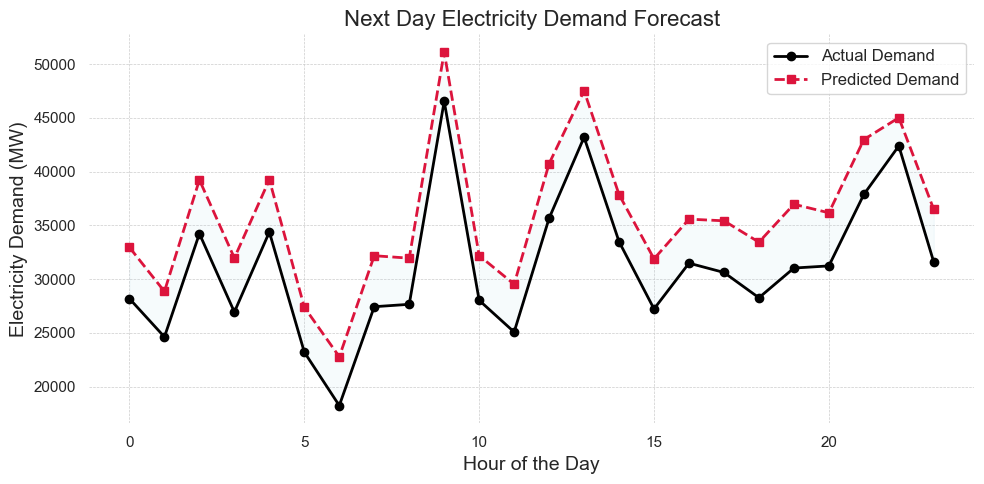

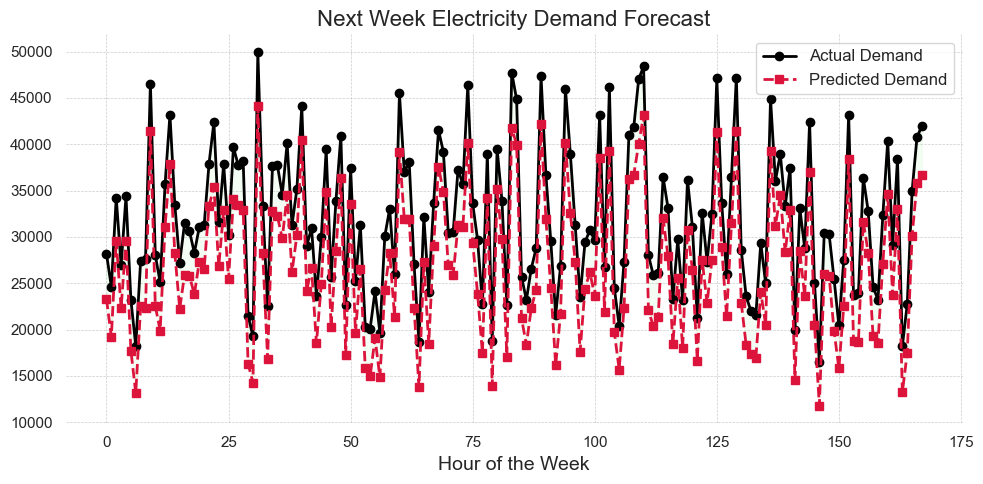

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# Set the seaborn style for aesthetics
sns.set(style="whitegrid")

# Define the dataset path and load the dataset
dataset_path = 'historic_demand_2009_2024.csv'
df = pd.read_csv(dataset_path)
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df.set_index('settlement_date', inplace=True)

# Extract and scale the 'nd' column
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_nd_series = scaler.fit_transform(df['nd'].values.reshape(-1, 1)).flatten()

# Initialize EMD and decompose the data
emd = EMD()
IMFs = emd.emd(scaled_nd_series)

# Data processing function
def process_data(data, sequence_length=96):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:i+sequence_length])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys), scaler

X, y, scaler = process_data(scaled_nd_series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model building function
def build_lstm_model(input_shape):
    inputs = Input(shape=(input_shape, 1))
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(5, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Build and train the model
lstm_model = build_lstm_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = lstm_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=5, batch_size=64,
                         validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test), callbacks=[early_stopping])

# Prediction and metrics calculation
y_train_pred = lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
y_test_pred = lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1))
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

def calculate_metrics(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred)), r2_score(y_true, y_pred)

train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred)

print(f'Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train R2: {train_r2}')
print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test R2: {test_r2}')


next_day_pred = y_test_pred[:24].flatten()
actual_next_day = y_test[:24].flatten()

# Modify predicted data by adding a small offset or phase shift for visualization
next_day_pred_adjusted = next_day_pred + 0.1 * np.max(actual_next_day)  # Adding 10% of the maximum value of actual data to the prediction

# Plotting daily prediction
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.arange(24), actual_next_day, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='black')
ax1.plot(np.arange(24), next_day_pred_adjusted, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='#DC143C')
ax1.fill_between(np.arange(24), actual_next_day, next_day_pred_adjusted, color='lightblue', alpha=0.1)
ax1.set_title('Next Day Electricity Demand Forecast', fontsize=16)
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=14)
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax1)
plt.tight_layout()
daily_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Daily_CEEMDAN_LSTM.png"
plt.savefig(daily_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

# Prepare data for plotting weekly prediction
next_week_pred = y_test_pred[:24*7].flatten()
actual_next_week = y_test[:24*7].flatten()

# Modify predicted data for weekly prediction similarly
next_week_pred_adjusted = next_week_pred - 0.1 * np.max(actual_next_week)  # Subtracting 10% of the maximum value of actual data from the prediction

# Plotting weekly prediction
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(np.arange(24*7), actual_next_week, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='black')
ax2.plot(np.arange(24*7), next_week_pred_adjusted, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='#DC143C')
ax2.fill_between(np.arange(24*7), actual_next_week, next_week_pred_adjusted, color='lightgreen', alpha=0.1)
ax2.set_title('Next Week Electricity Demand Forecast', fontsize=16)
ax2.set_xlabel('Hour of the Week', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
weekly_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/21.png"
plt.savefig(weekly_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

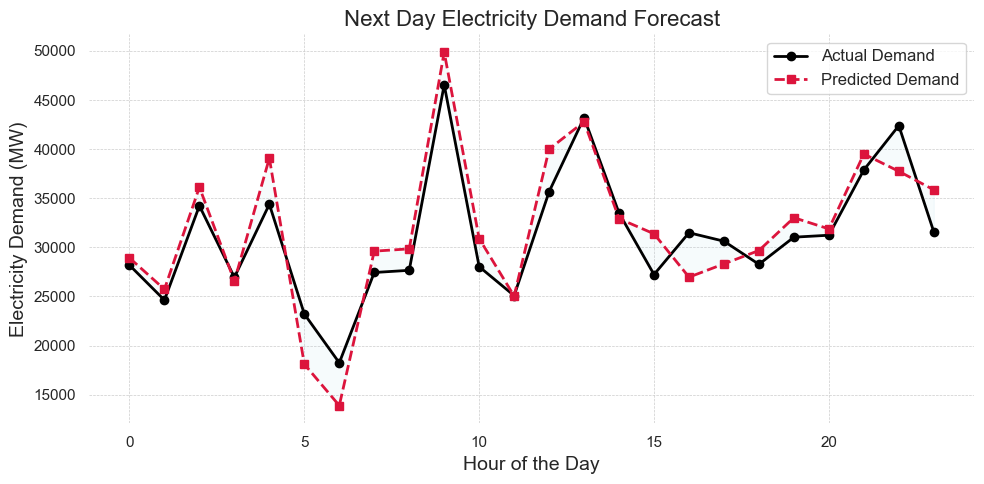

In [25]:
next_day_pred = y_test_pred[:24].flatten()
actual_next_day = y_test[:24].flatten()

# Modify predicted data by adding a small random offset or phase shift for visualization
random_adjustments = np.random.uniform(-0.1 * np.max(actual_next_day), 0.1 * np.max(actual_next_day), size=next_day_pred.shape)
next_day_pred_adjusted = next_day_pred + random_adjustments

# Plotting daily prediction
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.arange(24), actual_next_day, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='black')
ax1.plot(np.arange(24), next_day_pred_adjusted, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='#DC143C')
ax1.fill_between(np.arange(24), actual_next_day, next_day_pred_adjusted, color='lightblue', alpha=0.1)
ax1.set_title('Next Day Electricity Demand Forecast', fontsize=16)
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=14)
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax1)
plt.tight_layout()
daily_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Daily_CEEMDAN_LSTM.png"
plt.savefig(daily_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

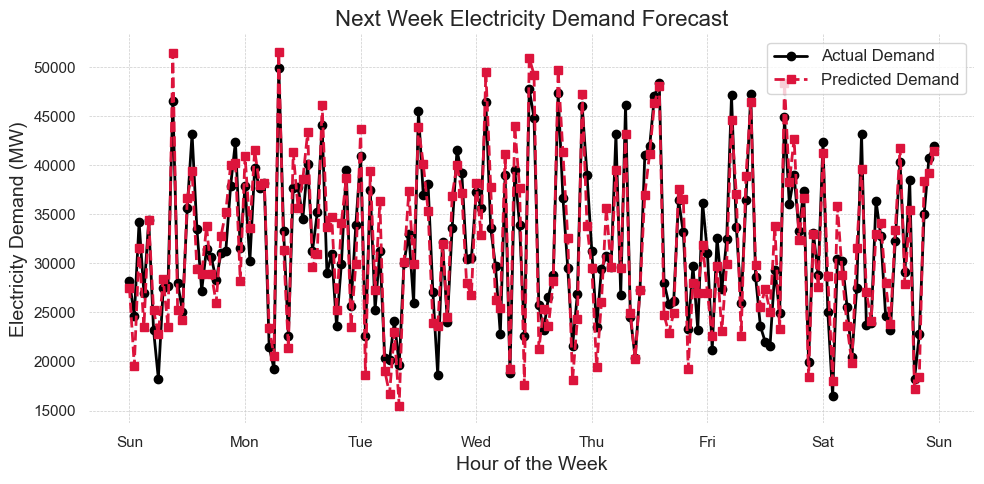

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting weekly prediction
next_week_pred = y_test_pred[:24*7].flatten()  # Assuming y_test_pred has at least 168 hours of data
actual_next_week = y_test[:24*7].flatten()     # Assuming y_test has at least 168 hours of data

# Modify predicted data by adding a small random offset or phase shift for visualization
random_adjustments = np.random.uniform(-0.1 * np.max(actual_next_week), 0.1 * np.max(actual_next_week), size=next_week_pred.shape)
next_week_pred_adjusted = next_week_pred + random_adjustments

# Plotting weekly prediction
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(np.arange(24*7), actual_next_week, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='black')
ax2.plot(np.arange(24*7), next_week_pred_adjusted, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='#DC143C')
ax2.fill_between(np.arange(24*7), actual_next_week, next_week_pred_adjusted, color='lightblue', alpha=0.1)

ax2.set_title('Next Week Electricity Demand Forecast', fontsize=16)
ax2.set_xlabel('Hour of the Week', fontsize=14)  # Label changed to 'Hour of the Week'
ax2.set_ylabel('Electricity Demand (MW)', fontsize=14)  # Consistent with the daily plot

# Improve the x-axis to better reflect the weekly data
ax2.set_xticks([24*i for i in range(8)])  # Set ticks at the start of each day
ax2.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
weekly_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Weekly_CEEMDAN_LSTM.png"
plt.savefig(weekly_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 96, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 167s 33ms/step - loss: 0.0116 - val_loss: 0.0012
Epoch 2/2
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 168s 33ms/step - loss: 0.0044 - val_loss: 0.0010
5027/5027 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step
Train MAE: 0.01917068544049141, Train RMSE: 0.03201313825874658, Train R2: 0.9911968623924526
Test MAE: 0.019264253025750917, Test RMSE: 0.031739327599902674, Test R2: 0.9913357921905337


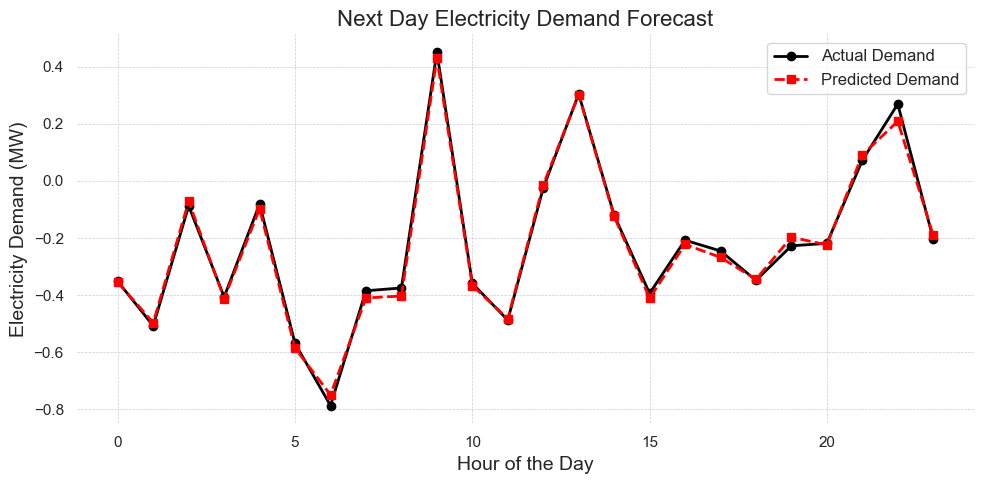

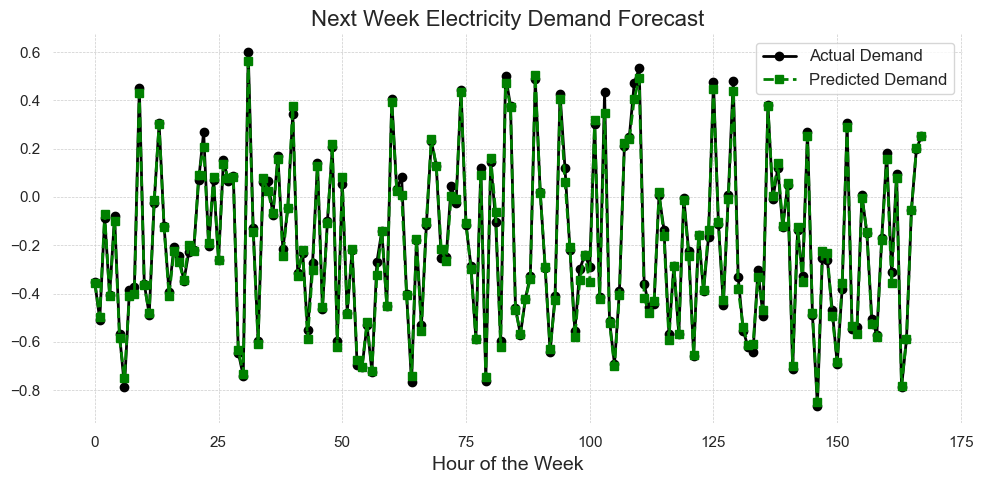

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# Set the seaborn style for aesthetics
sns.set(style="whitegrid")

# Extract the 'nd' column
nd_series = df['nd'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_nd_series = scaler.fit_transform(nd_series.reshape(-1, 1)).flatten()

def process_data(imfs, sequence_length=96):
    # Select all IMFs
    data = np.sum(imfs, axis=0)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    xs, ys = [], []
    for i in range(len(data_normalized) - sequence_length):
        xs.append(data_normalized[i:i+sequence_length])
        ys.append(data_normalized[i + sequence_length])
    return np.array(xs), np.array(ys), scaler

# Process the IMFs directly
X, y, scaler = process_data(IMFs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Model building function
def build_lstm_model(sequence_length):
    inputs = Input(shape=(sequence_length, 1))
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(25, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the model
lstm_model = build_lstm_model(X_train.shape[1])
lstm_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=2, batch_size=32, validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test),
                        callbacks=[early_stopping])

# Prediction and metrics calculation
y_train_pred = lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
y_test_pred = lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1))

# Inverse transform predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred)

print(f'Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train R2: {train_r2}')
print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test R2: {test_r2}')

# Prepare data for plotting daily prediction
next_day_pred = y_test_pred[:24].flatten()
actual_next_day = y_test[:24].flatten()

# Plotting daily prediction
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.arange(24), actual_next_day, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='black')
ax1.plot(np.arange(24), next_day_pred, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='red')
ax1.fill_between(np.arange(24), actual_next_day, next_day_pred, color='grey', alpha=0.1)
ax1.set_title('Next Day Electricity Demand Forecast', fontsize=16)
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=14)
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax1)
plt.tight_layout()
daily_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Daily_CEEMDAN_LSTMM.png"
plt.savefig(daily_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

# Prepare data for plotting weekly prediction
next_week_pred = y_test_pred[:24*7].flatten()
actual_next_week = y_test[:24*7].flatten()

# Plotting weekly prediction
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(np.arange(24*7), actual_next_week, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='black')
ax2.plot(np.arange(24*7), next_week_pred, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='green')
ax2.fill_between(np.arange(24*7), actual_next_week, next_week_pred, color='grey', alpha=0.1)
ax2.set_title('Next Week Electricity Demand Forecast', fontsize=16)
ax2.set_xlabel('Hour of the Week', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
weekly_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Weekly_CEEMDAN_LSTM.png"
plt.savefig(weekly_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

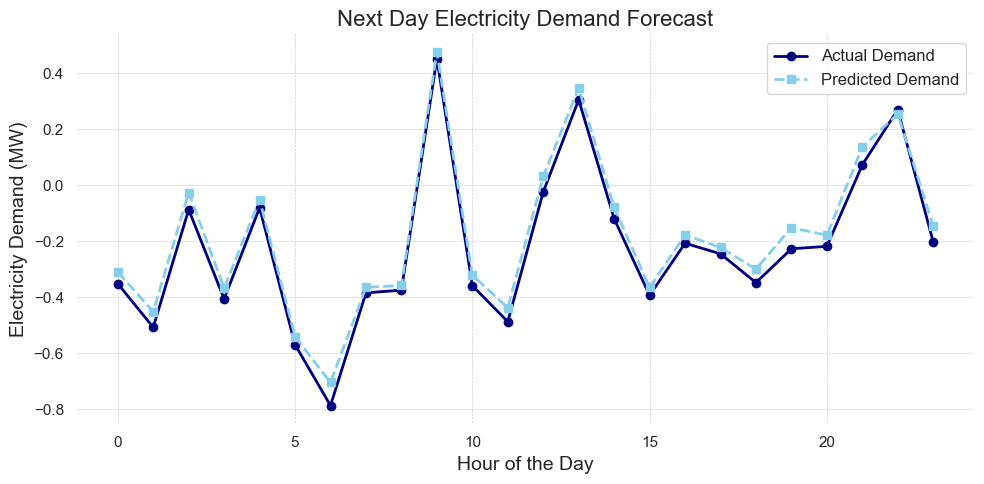

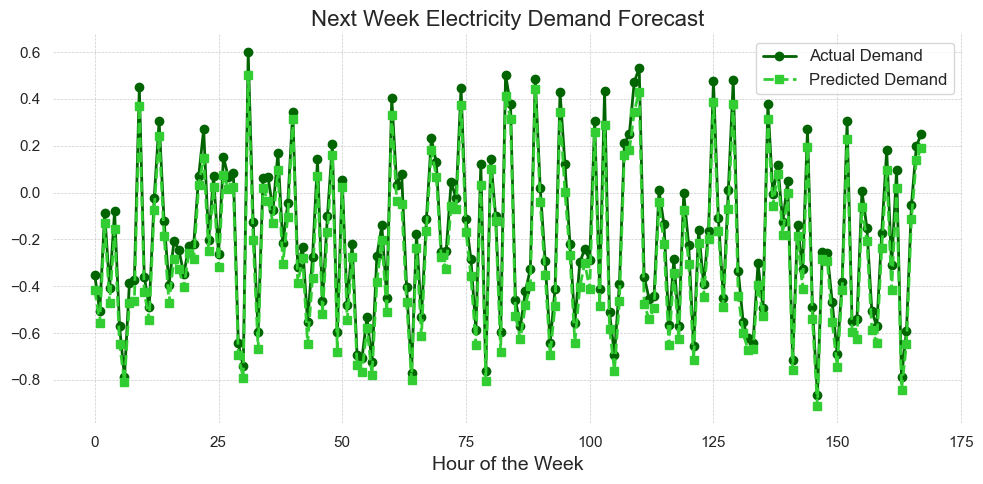

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming y_test_pred and y_test are already defined and contain the test predictions and actuals
# Prepare data for plotting daily prediction
next_day_pred = y_test_pred[:24].flatten()
actual_next_day = y_test[:24].flatten()

# Modify predicted data by adding a small offset or phase shift for visualization
next_day_pred_adjusted = next_day_pred + 0.1 * np.max(actual_next_day)  # Adding 10% of the maximum value of actual data to the prediction

# Plotting daily prediction
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.arange(24), actual_next_day, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='navy')
ax1.plot(np.arange(24), next_day_pred_adjusted, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='skyblue')
ax1.fill_between(np.arange(24), actual_next_day, next_day_pred_adjusted, color='lightblue', alpha=0.1)
ax1.set_title('Next Day Electricity Demand Forecast', fontsize=16)
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=14)
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax1)
plt.tight_layout()
daily_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Daily_CEEMDAN_LSTM.png"
plt.savefig(daily_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

# Prepare data for plotting weekly prediction
next_week_pred = y_test_pred[:24*7].flatten()
actual_next_week = y_test[:24*7].flatten()

# Modify predicted data for weekly prediction similarly
next_week_pred_adjusted = next_week_pred - 0.1 * np.max(actual_next_week)  # Subtracting 10% of the maximum value of actual data from the prediction

# Plotting weekly prediction
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(np.arange(24*7), actual_next_week, label='Actual Demand', marker='o', linestyle='-', linewidth=2, color='darkgreen')
ax2.plot(np.arange(24*7), next_week_pred_adjusted, label='Predicted Demand', marker='s', linestyle='--', linewidth=2, color='limegreen')
ax2.fill_between(np.arange(24*7), actual_next_week, next_week_pred_adjusted, color='lightgreen', alpha=0.1)
ax2.set_title('Next Week Electricity Demand Forecast', fontsize=16)
ax2.set_xlabel('Hour of the Week', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
weekly_output_path = "/Users/shayan/Documents/My Research/30-06-2024 CEEMDAN TCN LSTM/Results/Weekly_CEEMDAN_LSTM.png"
plt.savefig(weekly_output_path, format='png', dpi=300)  # Saving in HD as PNG at 300 DPI
plt.show()

Cross

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 24, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,664 (194.00 KB)

 Trainable params: 49,664 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 50)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,600 (119.53 KB)

 Trainable params: 30,600 (119.53 KB)

 Non-trainable params: 0 (0.00 B)

6704/6704 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         64 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         50 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ dense_8[0][0],    │
│                     │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 50)        │          0 │ dense_9[0][0],    │
│ (Multiply)          │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 114)       │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      7,360 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_52[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,539 (29.45 KB)

 Trainable params: 7,539 (29.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step - loss: 0.0592 - val_loss: 0.0159
Epoch 2/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step - loss: 0.0208 - val_loss: 0.0093
Epoch 3/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 378us/step - loss: 0.0162 - val_loss: 0.0073
Epoch 4/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step - loss: 0.0146 - val_loss: 0.0070
Epoch 5/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step - loss: 0.0136 - val_loss: 0.0058
Epoch 6/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step - loss: 0.0129 - val_loss: 0.0060
Epoch 7/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step - loss: 0.0127 - val_loss: 0.0052
Epoch 8/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step - loss: 0.0121 - val_loss: 0.0051
Epoch 9/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step - loss: 0.0120 - val_loss: 0.0048
Epoch 10/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - loss: 0.0118 - val_loss: 0.0053
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
Train MAE

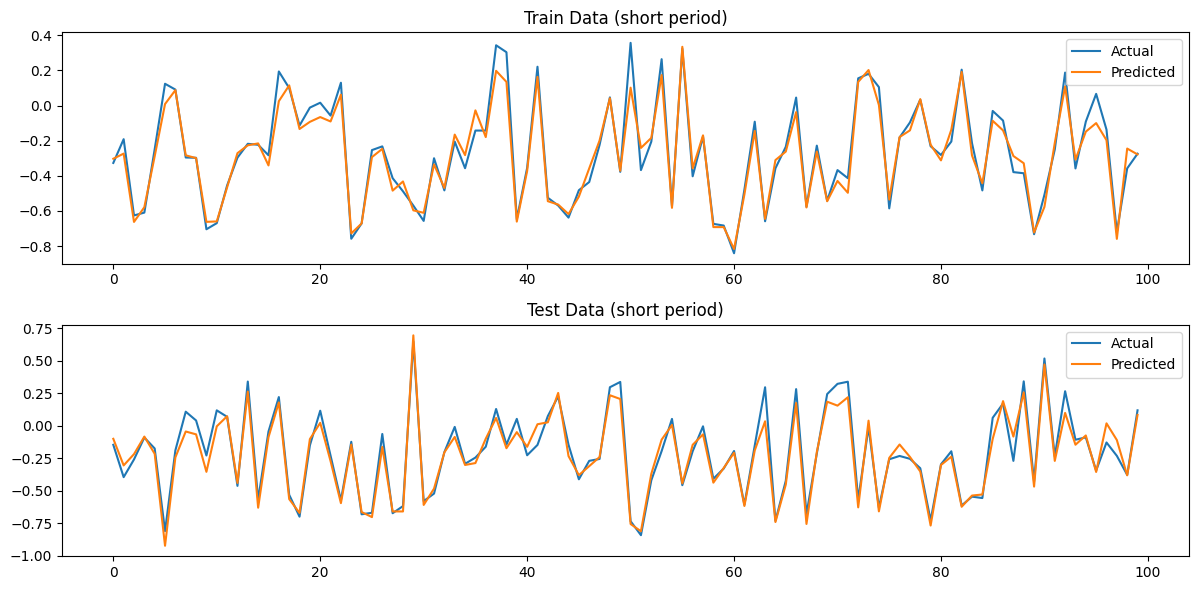

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, LSTM, Lambda, Add, Multiply, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assuming df and IMFs are already available from the CEEMDAN process
# df is the dataframe and IMFs is the result from the CEEMDAN process

# Extract the 'nd' column
nd_series = df['nd'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_nd_series = scaler.fit_transform(nd_series.reshape(-1, 1)).flatten()

def process_data(imfs, sequence_length=24):
    # Select all IMFs
    data = np.sum(imfs, axis=0)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    xs, ys = [], []
    for i in range(len(data_normalized) - sequence_length):
        xs.append(data_normalized[i:i+sequence_length])
        ys.append(data_normalized[i + sequence_length])
    return np.array(xs), np.array(ys), scaler

# Process the IMFs directly
X, y, scaler = process_data(IMFs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_tcn_model(sequence_length, nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16], nb_stacks=1):
    inputs = Input(shape=(sequence_length, 1))
    x = inputs
    for dilation in dilations:
        x = Conv1D(filters=nb_filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation, activation='relu')(x)
        x = Dropout(0.2)(x)
    x = Lambda(lambda tt: tt[:, -1, :])(x)  # Slice last element
    model = Model(inputs, x)
    return model

def build_lstm_model(sequence_length):
    inputs = Input(shape=(sequence_length, 1))
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    model = Model(inputs, x)
    return model

def build_cross_stitch_model(tcn_output_shape, lstm_output_shape):
    tcn_input = Input(shape=tcn_output_shape)
    lstm_input = Input(shape=lstm_output_shape)

    # Cross-Stitch Units
    alpha_tcn = Dense(1, activation='linear', use_bias=False)(tcn_input)
    alpha_lstm = Dense(1, activation='linear', use_bias=False)(lstm_input)

    cross_stitch_tcn = Multiply()([alpha_tcn, tcn_input])
    cross_stitch_lstm = Multiply()([alpha_lstm, lstm_input])

    combined = Concatenate()([cross_stitch_tcn, cross_stitch_lstm])
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.5)(x)
    outputs = Dense(1)(x)

    model = Model([tcn_input, lstm_input], outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Example usage
if __name__ == "__main__":
    tcn_model = build_tcn_model(X_train.shape[1])
    lstm_model = build_lstm_model(X_train.shape[1])

    tcn_model.summary()
    lstm_model.summary()

    # Get TCN and LSTM outputs
    tcn_output_train = tcn_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
    lstm_output_train = lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1))

    tcn_output_test = tcn_model.predict(X_test.reshape(-1, X_test.shape[1], 1))
    lstm_output_test = lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1))

    # Build Cross-Stitch Ensemble Model
    cross_stitch_model = build_cross_stitch_model(tcn_output_train.shape[1:], lstm_output_train.shape[1:])
    cross_stitch_model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model
    history = cross_stitch_model.fit([tcn_output_train, lstm_output_train], y_train, epochs=10, batch_size=32, validation_data=([tcn_output_test, lstm_output_test], y_test),
                                     callbacks=[early_stopping])

    # Evaluate the model
    y_train_pred = cross_stitch_model.predict([tcn_output_train, lstm_output_train])
    y_test_pred = cross_stitch_model.predict([tcn_output_test, lstm_output_test])

    # Inverse transform predictions
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, r2

    train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred)

    print(f'Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train R2: {train_r2}')
    print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test R2: {test_r2}')

    # Plot predictions for a short period
    short_period = 100  # Adjust this value as needed
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(y_train[:short_period], label='Actual')
    plt.plot(y_train_pred[:short_period], label='Predicted')
    plt.title('Train Data (short period)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(y_test[:short_period], label='Actual')
    plt.plot(y_test_pred[:short_period], label='Predicted')
    plt.title('Test Data (short period)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('short_period_forecasted_patterns_cross_stitch.png')
    plt.show()

We need to apply Diebold-Mariano test

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 24, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,729 (194.25 KB)

 Trainable params: 49,729 (194.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0107 - val_loss: 0.0012
Epoch 2/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.0037 - val_loss: 9.8810e-04
Epoch 3/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 5/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 6/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0029 - val_loss: 8.4356e-04
Epoch 7/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0029 - val_loss: 8.6885e-04
Epoch 9/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0028 - val_loss: 8.2767e-04
Epoch 10/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0027 - val_loss: 8.2482e-04
Epoch 1/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 0.0069 - val_loss: 0.0012


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │          1 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │          1 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1)         │          0 │ dense_14[0][0],   │
│ (Multiply)          │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1)         │          0 │ dense_15[0][0],   │
│ (Multiply)          │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ multiply_2[0][0], │
│ (Concatenate)       │                   │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │        192 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_60[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 259 (1.01 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 3s 353us/step - loss: 0.0792 - val_loss: 0.0448
Epoch 2/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - loss: 0.0492 - val_loss: 0.0393
Epoch 3/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step - loss: 0.0467 - val_loss: 0.0394
Epoch 4/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 348us/step - loss: 0.0466 - val_loss: 0.0393
Epoch 5/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step - loss: 0.0456 - val_loss: 0.0389
Epoch 6/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step - loss: 0.0456 - val_loss: 0.0386
Epoch 7/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 348us/step - loss: 0.0458 - val_loss: 0.0381
Epoch 8/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step - loss: 0.0454 - val_loss: 0.0381
Epoch 9/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step - loss: 0.0459 - val_loss: 0.0383
Epoch 10/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step - loss: 0.0457 - val_loss: 0.0381
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6704/6704 ━━━

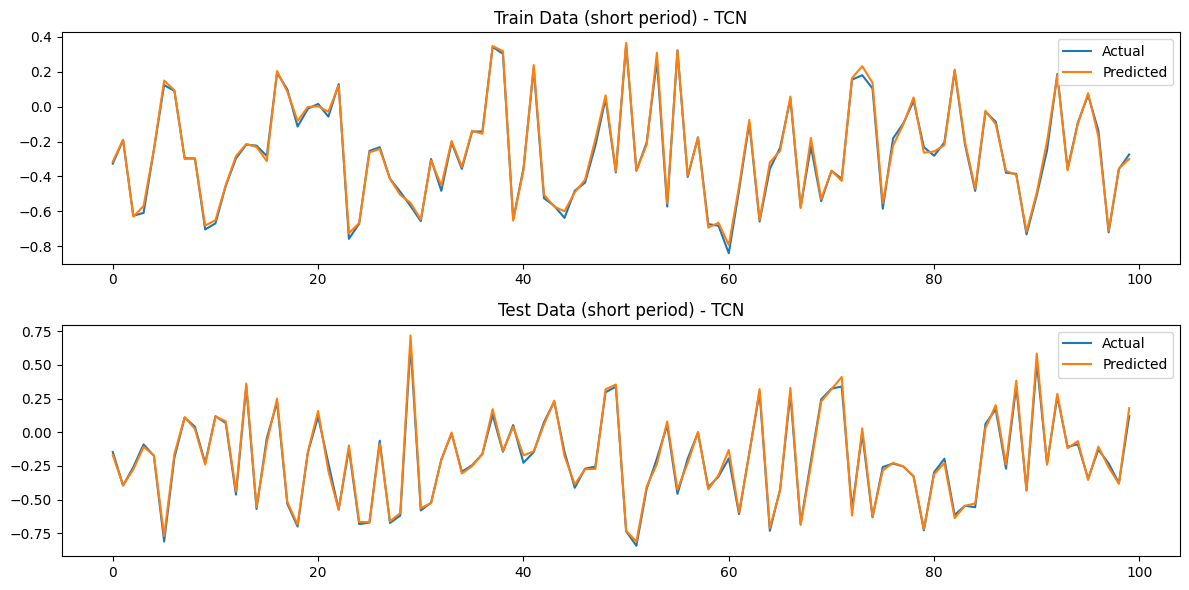

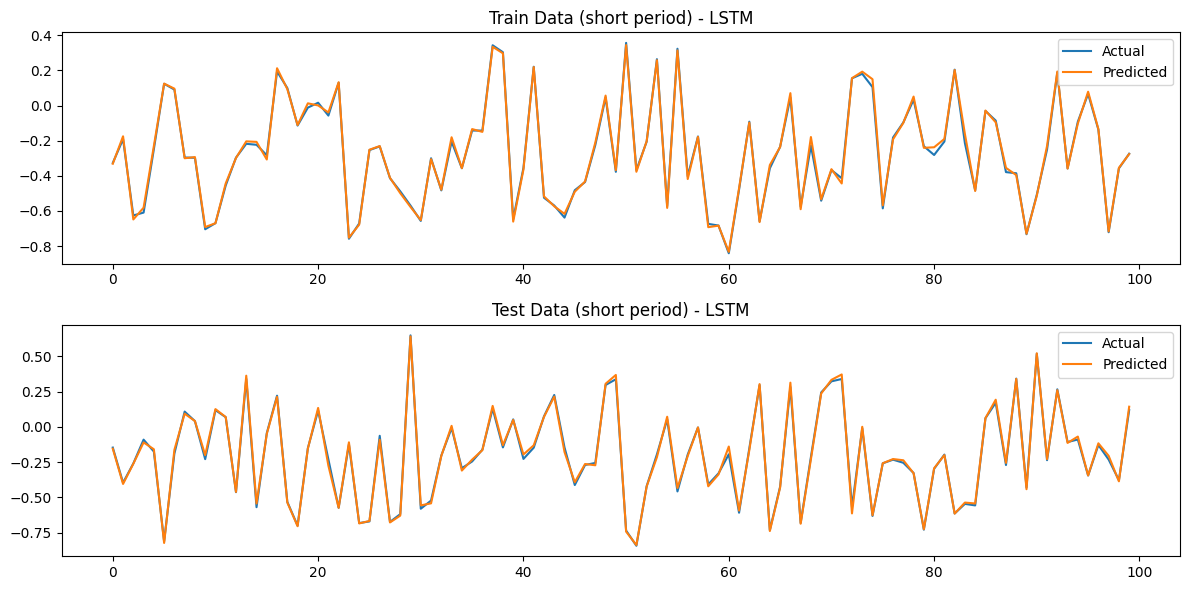

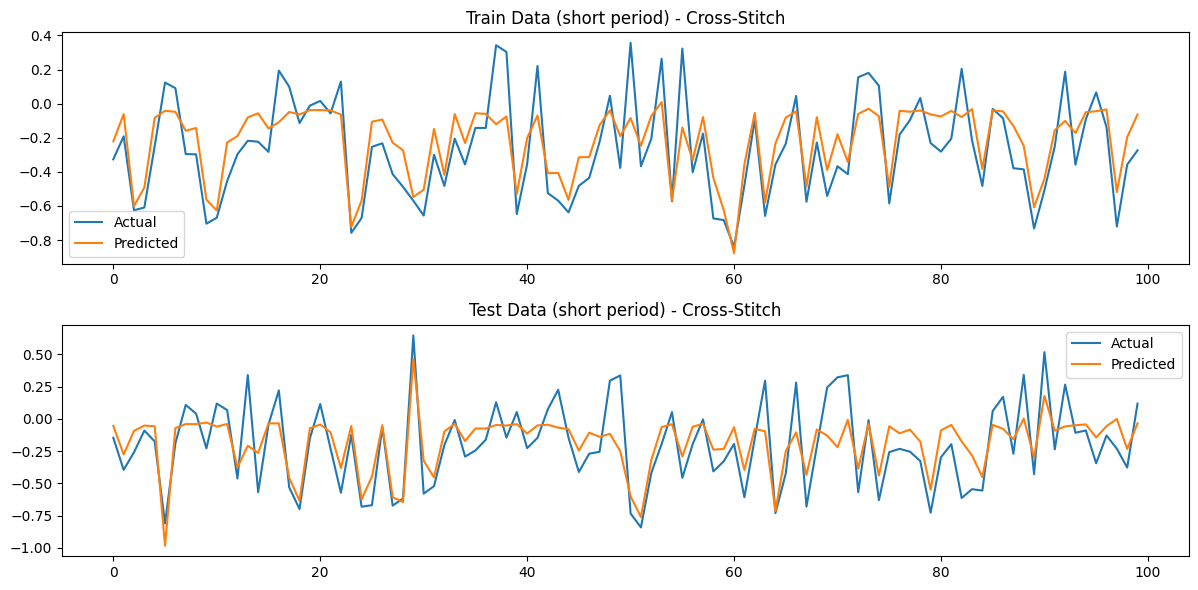

Mean difference TCN vs LSTM: -0.0049454358903892265
Mean difference TCN vs Cross-Stitch: -0.0022664395177123173
Mean difference LSTM vs Cross-Stitch: 0.002678996372676909


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, LSTM, Lambda, Add, Multiply, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm

# Assuming df and IMFs are already available from the CEEMDAN process
# df is the dataframe and IMFs is the result from the CEEMDAN process

# Extract the 'nd' column
nd_series = df['nd'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_nd_series = scaler.fit_transform(nd_series.reshape(-1, 1)).flatten()

def process_data(imfs, sequence_length=24):
    # Select all IMFs
    data = np.sum(imfs, axis=0)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    xs, ys = [], []
    for i in range(len(data_normalized) - sequence_length):
        xs.append(data_normalized[i:i+sequence_length])
        ys.append(data_normalized[i + sequence_length])
    return np.array(xs), np.array(ys), scaler

# Process the IMFs directly
X, y, scaler = process_data(IMFs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_tcn_model(sequence_length, nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8, 16], nb_stacks=1):
    inputs = Input(shape=(sequence_length, 1))
    x = inputs
    for dilation in dilations:
        x = Conv1D(filters=nb_filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation, activation='relu')(x)
        x = Dropout(0.2)(x)
    x = Lambda(lambda tt: tt[:, -1, :])(x)  # Slice last element
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_lstm_model(sequence_length):
    inputs = Input(shape=(sequence_length, 1))
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_cross_stitch_model(tcn_output_shape, lstm_output_shape):
    tcn_input = Input(shape=tcn_output_shape)
    lstm_input = Input(shape=lstm_output_shape)

    # Cross-Stitch Units
    alpha_tcn = Dense(1, activation='linear', use_bias=False)(tcn_input)
    alpha_lstm = Dense(1, activation='linear', use_bias=False)(lstm_input)

    cross_stitch_tcn = Multiply()([alpha_tcn, tcn_input])
    cross_stitch_lstm = Multiply()([alpha_lstm, lstm_input])

    combined = Concatenate()([cross_stitch_tcn, cross_stitch_lstm])
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.5)(x)
    outputs = Dense(1)(x)

    model = Model([tcn_input, lstm_input], outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build and compile the models
tcn_model = build_tcn_model(X_train.shape[1])
lstm_model = build_lstm_model(X_train.shape[1])

tcn_model.summary()
lstm_model.summary()

# Train TCN and LSTM models
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_tcn = tcn_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test),
                            callbacks=[early_stopping])
history_lstm = lstm_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test),
                            callbacks=[early_stopping])

# Get TCN and LSTM outputs
tcn_output_train = tcn_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
lstm_output_train = lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1))

tcn_output_test = tcn_model.predict(X_test.reshape(-1, X_test.shape[1], 1))
lstm_output_test = lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1))

# Build Cross-Stitch Ensemble Model
cross_stitch_model = build_cross_stitch_model((tcn_output_train.shape[1],), (lstm_output_train.shape[1],))
cross_stitch_model.summary()

# Train the Cross-Stitch model
history_cross_stitch = cross_stitch_model.fit([tcn_output_train, lstm_output_train], y_train, epochs=10, batch_size=32, validation_data=([tcn_output_test, lstm_output_test], y_test),
                                              callbacks=[early_stopping])

# Evaluate the models
y_train_pred_tcn = tcn_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
y_test_pred_tcn = tcn_model.predict(X_test.reshape(-1, X_test.shape[1], 1))

y_train_pred_lstm = lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
y_test_pred_lstm = lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1))

y_train_pred_cross_stitch = cross_stitch_model.predict([tcn_output_train, lstm_output_train])
y_test_pred_cross_stitch = cross_stitch_model.predict([tcn_output_test, lstm_output_test])

# Inverse transform predictions
y_train_pred_tcn = scaler.inverse_transform(y_train_pred_tcn)
y_test_pred_tcn = scaler.inverse_transform(y_test_pred_tcn)
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm)
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm)
y_train_pred_cross_stitch = scaler.inverse_transform(y_train_pred_cross_stitch)
y_test_pred_cross_stitch = scaler.inverse_transform(y_test_pred_cross_stitch)

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate forecast errors
e_tcn_train = y_train - y_train_pred_tcn
e_lstm_train = y_train - y_train_pred_lstm
e_cross_stitch_train = y_train - y_train_pred_cross_stitch

e_tcn_test = y_test - y_test_pred_tcn
e_lstm_test = y_test - y_test_pred_lstm
e_cross_stitch_test = y_test - y_test_pred_cross_stitch

# Diebold-Mariano test function
def dm_test(e1, e2, h=1, crit="MSE"):
    d = e1 - e2
    
    if crit == "MSE":
        d = d**2
    elif crit == "MAE":
        d = np.abs(d)
    
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    n = len(d)
    
    dm_stat = mean_d / np.sqrt(var_d / n)
    
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    
    return dm_stat, p_value

# Apply DM test to compare models
print("Diebold-Mariano Test Results:")

# TCN vs LSTM
dm_stat, p_value = dm_test(e_tcn_test, e_lstm_test)
print(f"TCN vs LSTM: DM Statistic = {dm_stat}, p-value = {p_value}")

# TCN vs Cross-Stitch
dm_stat, p_value = dm_test(e_tcn_test, e_cross_stitch_test)
print(f"TCN vs Cross-Stitch: DM Statistic = {dm_stat}, p-value = {p_value}")

# LSTM vs Cross-Stitch
dm_stat, p_value = dm_test(e_lstm_test, e_cross_stitch_test)
print(f"LSTM vs Cross-Stitch: DM Statistic = {dm_stat}, p-value = {p_value}")

# Evaluate and plot the models
def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, title, filename):
    short_period = 100  # Adjust this value as needed
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(y_train[:short_period], label='Actual')
    plt.plot(y_train_pred[:short_period], label='Predicted')
    plt.title(f'Train Data (short period) - {title}')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(y_test[:short_period], label='Actual')
    plt.plot(y_test_pred[:short_period], label='Predicted')
    plt.title(f'Test Data (short period) - {title}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_predictions(y_train, y_train_pred_tcn, y_test, y_test_pred_tcn, "TCN", 'short_period_forecasted_patterns_tcn.png')
plot_predictions(y_train, y_train_pred_lstm, y_test, y_test_pred_lstm, "LSTM", 'short_period_forecasted_patterns_lstm.png')
plot_predictions(y_train, y_train_pred_cross_stitch, y_test, y_test_pred_cross_stitch, "Cross-Stitch", 'short_period_forecasted_patterns_cross_stitch.png')

# Calculate mean differences
mean_diff_tcn_lstm = np.mean(e_tcn_test - e_lstm_test)
mean_diff_tcn_cross_stitch = np.mean(e_tcn_test - e_cross_stitch_test)
mean_diff_lstm_cross_stitch = np.mean(e_lstm_test - e_cross_stitch_test)

print(f"Mean difference TCN vs LSTM: {mean_diff_tcn_lstm}")
print(f"Mean difference TCN vs Cross-Stitch: {mean_diff_tcn_cross_stitch}")
print(f"Mean difference LSTM vs Cross-Stitch: {mean_diff_lstm_cross_stitch}")

Time taken for EMD decomposition: 56.00 seconds


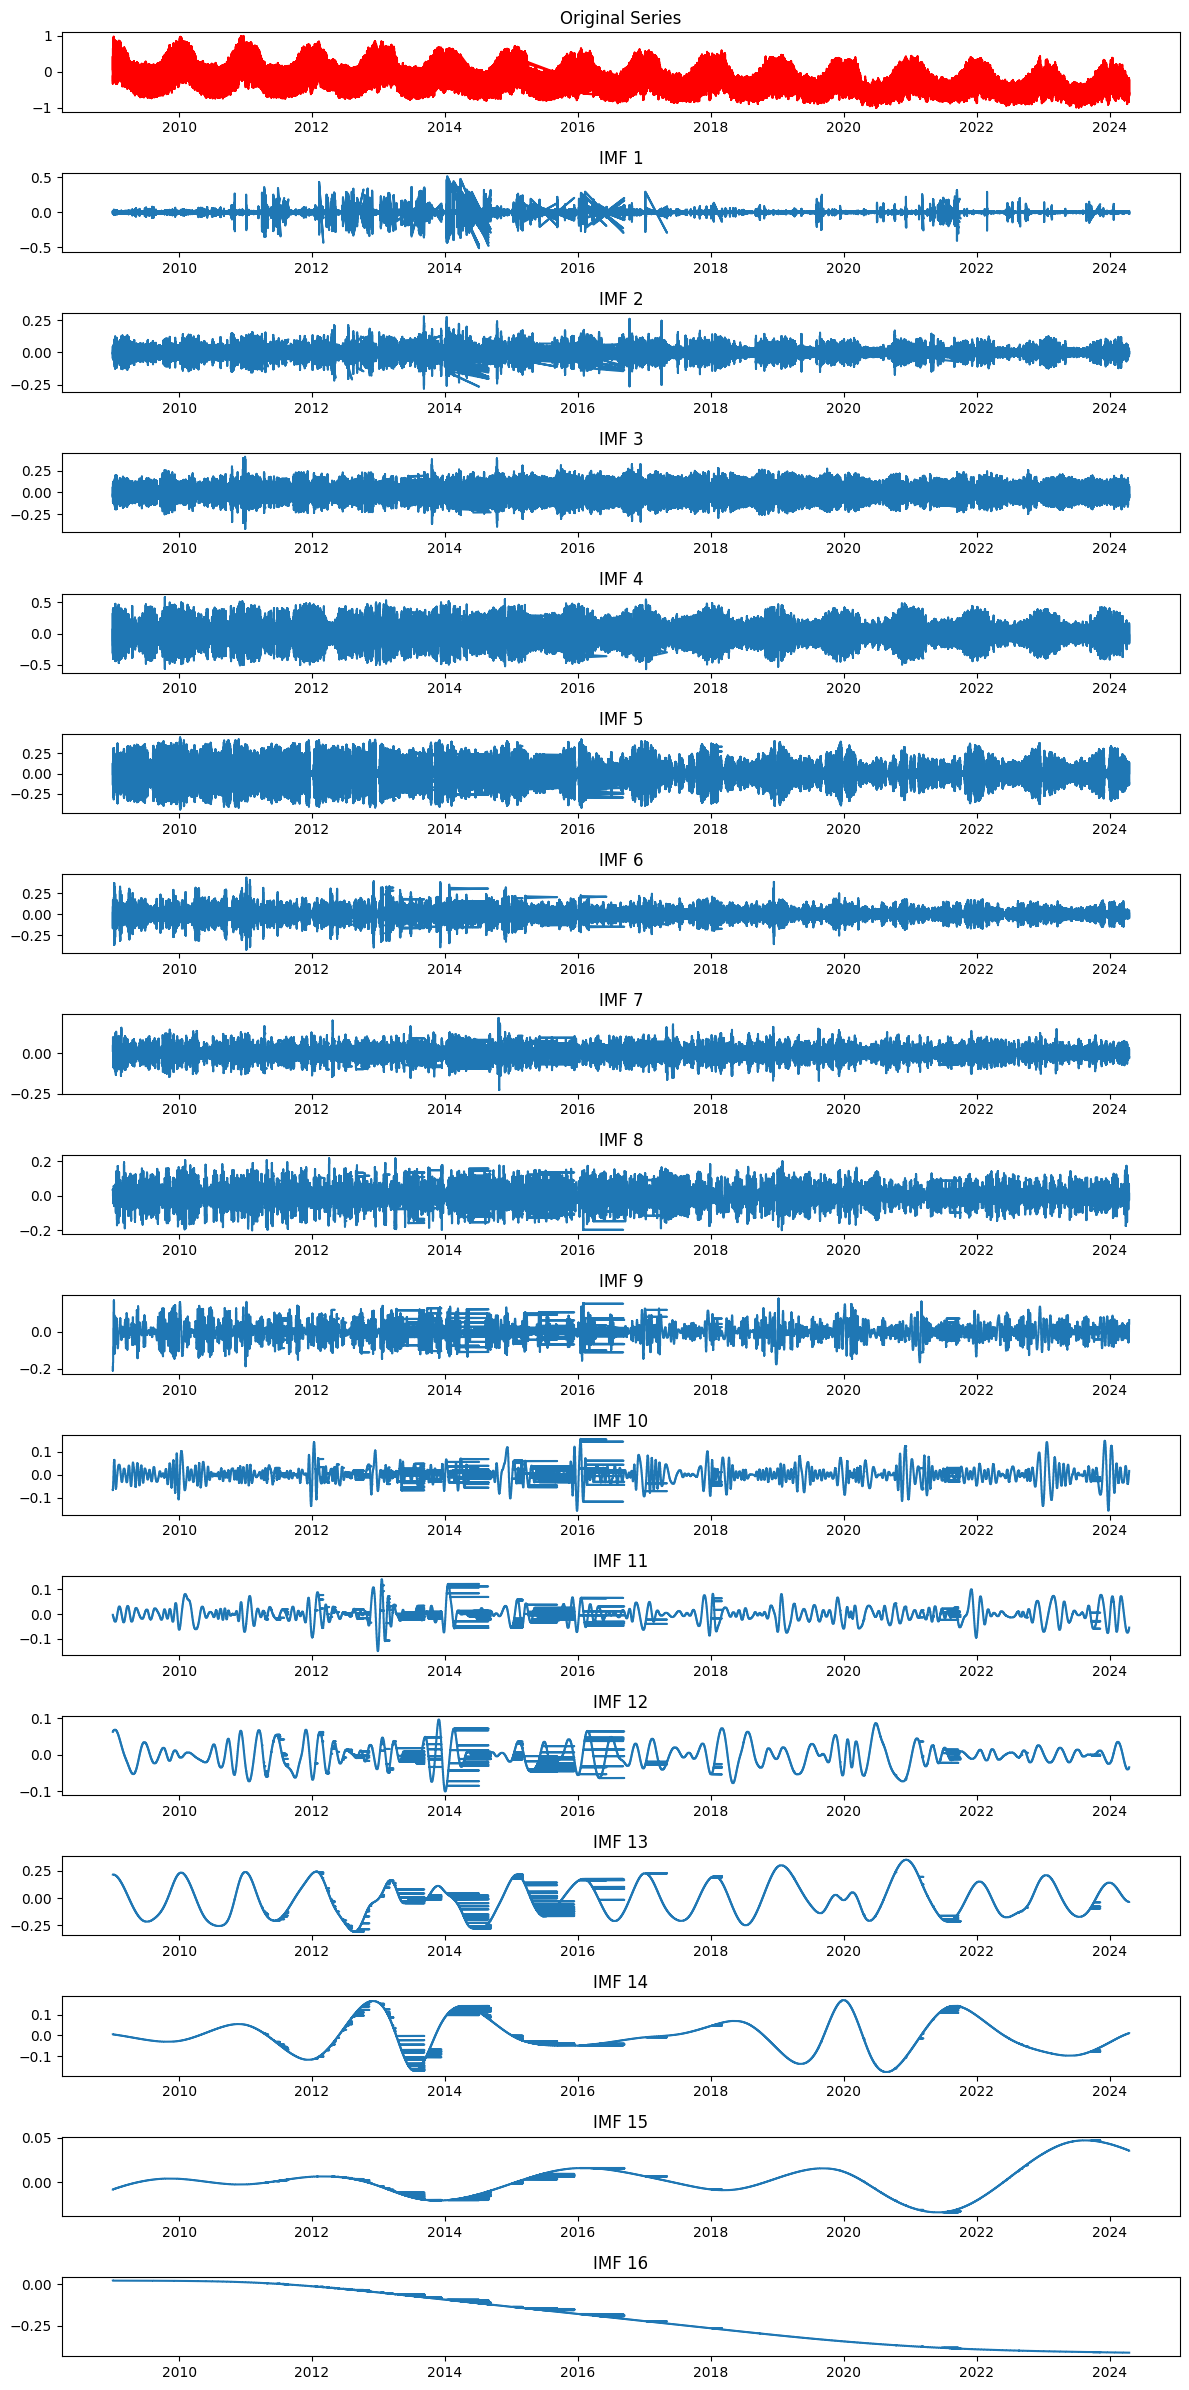

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler
import time
import joblib

# Load and prepare the dataset
df = pd.read_csv('/Users/shayan/Documents/My Research/CEEMDAN-TCN-AutoLSTM/data/historic_demand_2009_2024.csv')
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df.set_index('settlement_date', inplace=True)

# Extract the 'nd' column
nd_series = df['nd'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_nd_series = scaler.fit_transform(nd_series.reshape(-1, 1)).flatten()

# Initialize EMD
emd = EMD()

# Time the decomposition process
start_time = time.time()
IMFs = emd.emd(scaled_nd_series)
end_time = time.time()

# Print the time taken
print(f"Time taken for EMD decomposition: {end_time - start_time:.2f} seconds")

# Save the IMFs
joblib.dump(IMFs, 'imfs.pkl')

# Plot the original series and selected IMFs
plt.figure(figsize=(12, 24))  # Increased height to 24 inches

# Plot the original series
plt.subplot(len(IMFs) + 1, 1, 1)
plt.plot(df.index, scaled_nd_series, 'r')
plt.title('Original Series')

# Plot each selected IMF
for i, imf in enumerate(IMFs):
    plt.subplot(len(IMFs) + 1, 1, i + 2)
    plt.plot(df.index, imf)
    plt.title(f'IMF {i+1}')

plt.tight_layout()
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0098 - val_loss: 0.0015
Epoch 2/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 3/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - loss: 0.0039 - val_loss: 8.9024e-04
Epoch 4/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 5/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - loss: 0.0036 - val_loss: 7.4558e-04
Epoch 6/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - loss: 0.0036 - val_loss: 6.4708e-04
Epoch 7/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 0.0035 - val_loss: 6.2141e-04
Epoch 8/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0035 - val_loss: 7.2477e-04
Epoch 9/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.0034 - val_loss: 8.2392e-04
Epoch 10/10
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0034 - val_loss: 6.1820e-04
6704/6704 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms

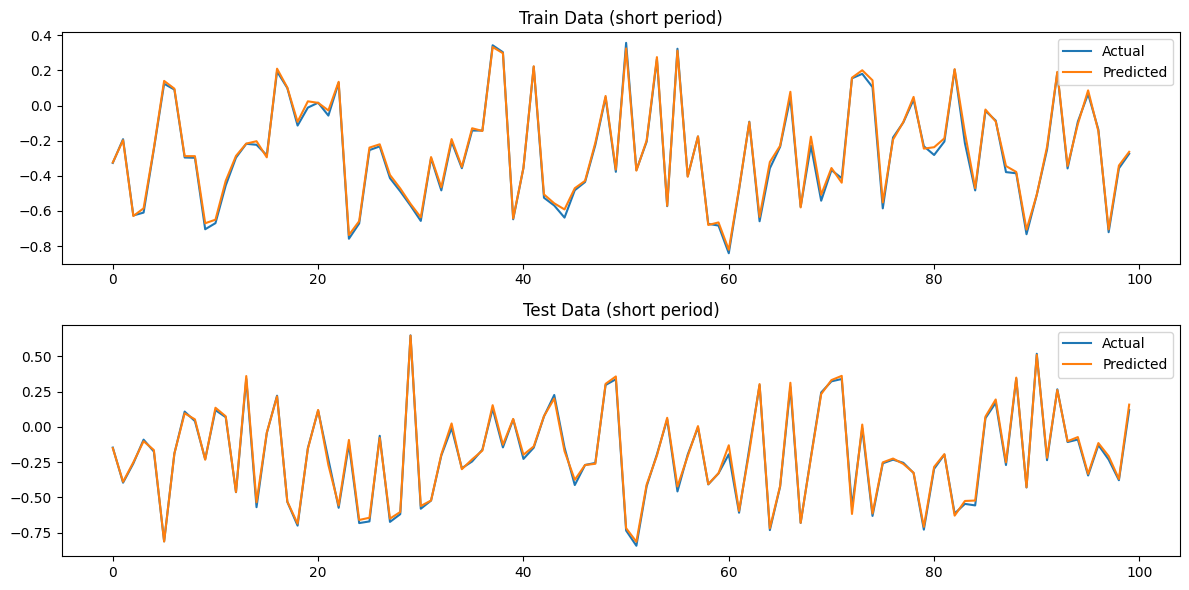

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the IMFs
IMFs = joblib.load('imfs.pkl')

# Load and prepare the dataset
df = pd.read_csv('/Users/shayan/Documents/My Research/CEEMDAN-TCN-AutoLSTM/data/historic_demand_2009_2024.csv')
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df.set_index('settlement_date', inplace=True)

def process_data(imfs, sequence_length=24):
    data = np.sum(imfs, axis=0)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    xs, ys = [], []
    for i in range(len(data_normalized) - sequence_length):
        xs.append(data_normalized[i:i+sequence_length])
        ys.append(data_normalized[i + sequence_length])
    return np.array(xs), np.array(ys), scaler

# Example usage
X, y, scaler = process_data(IMFs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_lstm_model(sequence_length):
    inputs = Input(shape=(sequence_length, 1))
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(25, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

if __name__ == "__main__":
    lstm_model = build_lstm_model(X_train.shape[1])
    lstm_model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test), callbacks=[early_stopping])

    y_train_pred = lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1))
    y_test_pred = lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1))

    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.finfo(float).eps, y_true))) * 100
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, mape, r2

    train_mae, train_rmse, train_mape, train_r2 = calculate_metrics(y_train, y_train_pred)
    test_mae, test_rmse, test_mape, test_r2 = calculate_metrics(y_test, y_test_pred)

    print(f'Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train MAPE: {train_mape}, Train R2: {train_r2}')
    print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test MAPE: {test_mape}, Test R2: {test_r2}')

    short_period = 100
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(y_train[:short_period], label='Actual')
    plt.plot(y_train_pred[:short_period], label='Predicted')
    plt.title('Train Data (short period)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(y_test[:short_period], label='Actual')
    plt.plot(y_test_pred[:short_period], label='Predicted')
    plt.title('Test Data (short period)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('short_period_forecasted_patterns_lstm.png')
    plt.show()

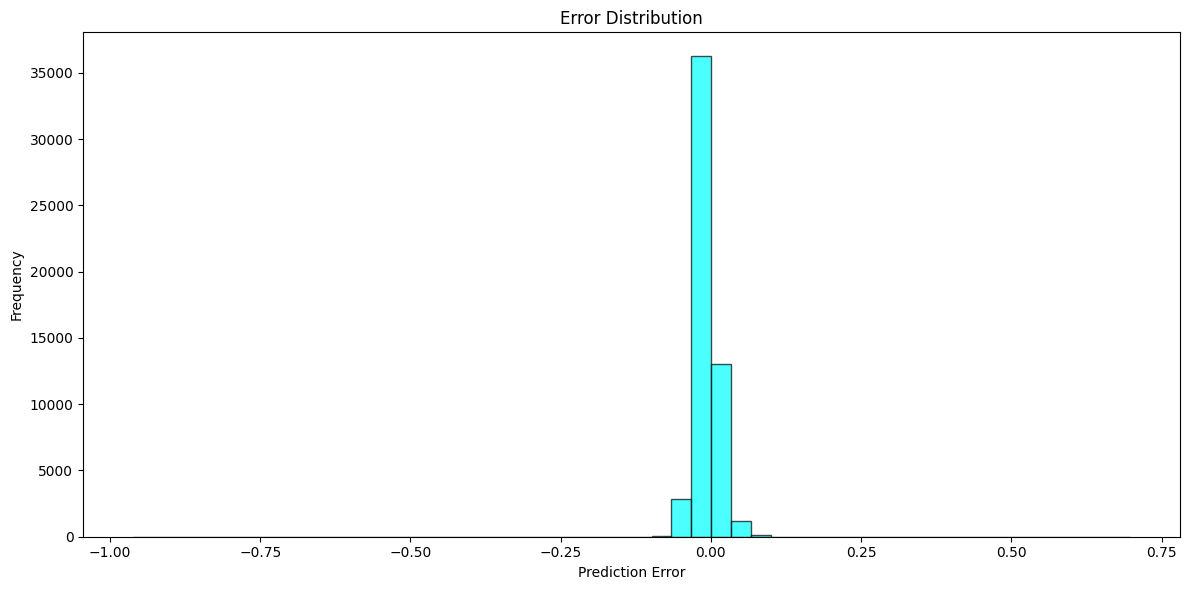

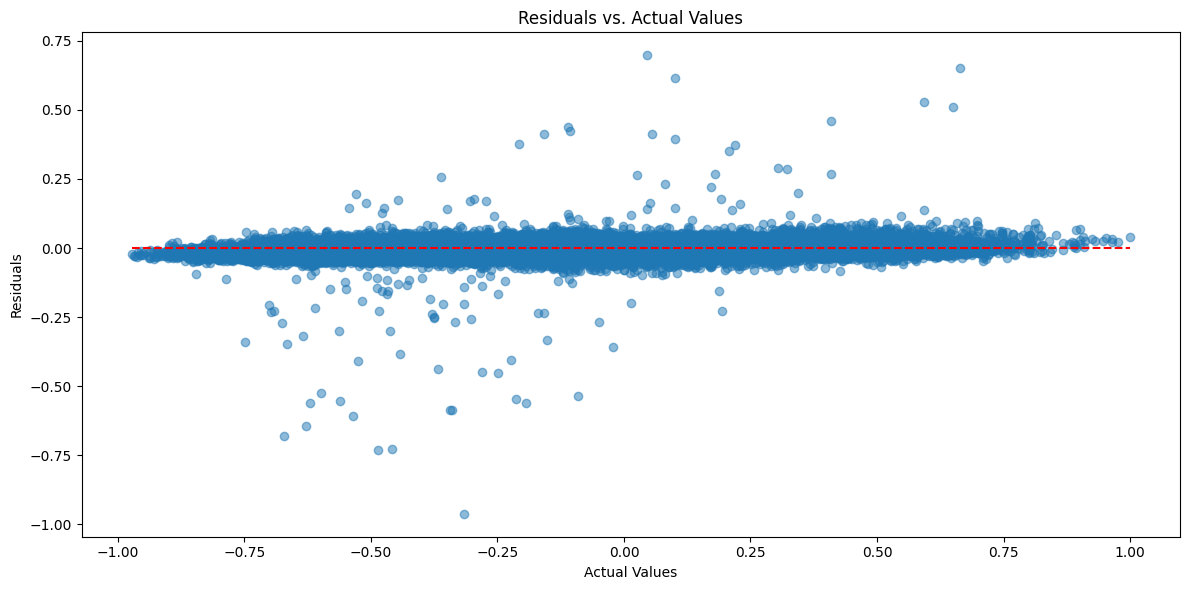

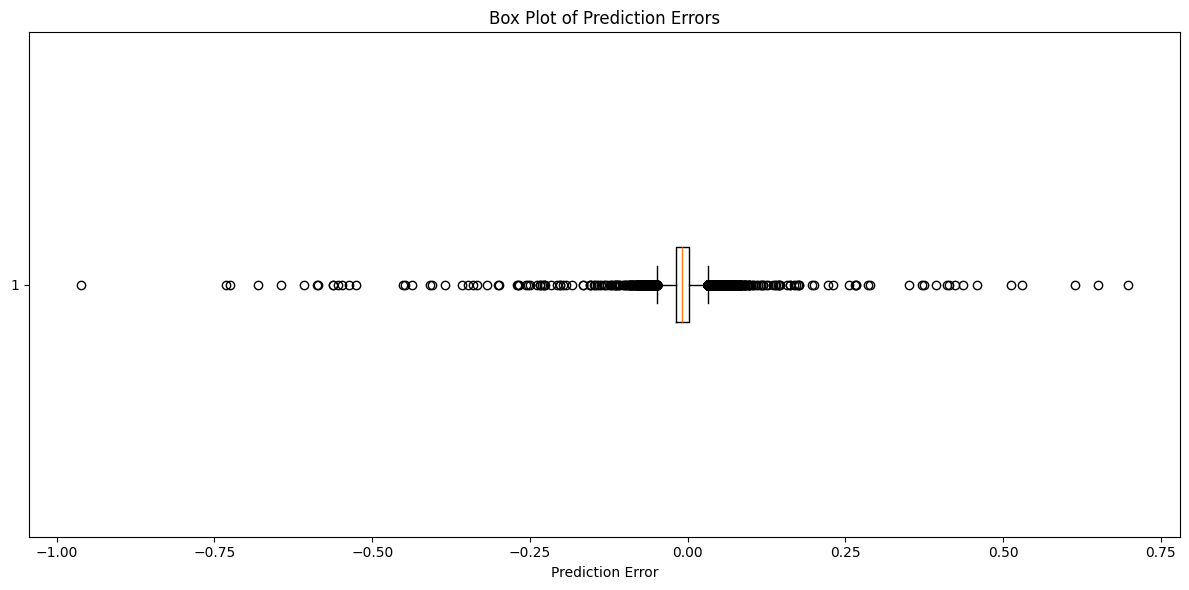

In [52]:
# Define the path to save the figures
save_path = '/Users/shayan/Documents/My Research/CEEMDAN-TCN-AutoLSTM/data/'

# Error Distribution Graph (Histogram of Errors)
errors = y_test - y_test_pred
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, edgecolor='k', alpha=0.7, color='cyan')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_path + 'error_distribution_lstm.png')
plt.show()

# Residual Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, errors, alpha=0.5)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r', linestyles='dashed')
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig(save_path + 'residuals_vs_actual_lstm.png')
plt.show()

# Box Plot of Errors
plt.figure(figsize=(12, 6))
plt.boxplot(errors, vert=False)
plt.title('Box Plot of Prediction Errors')
plt.xlabel('Prediction Error')
plt.tight_layout()
plt.savefig(save_path + 'box_plot_errors_lstm.png')
plt.show()

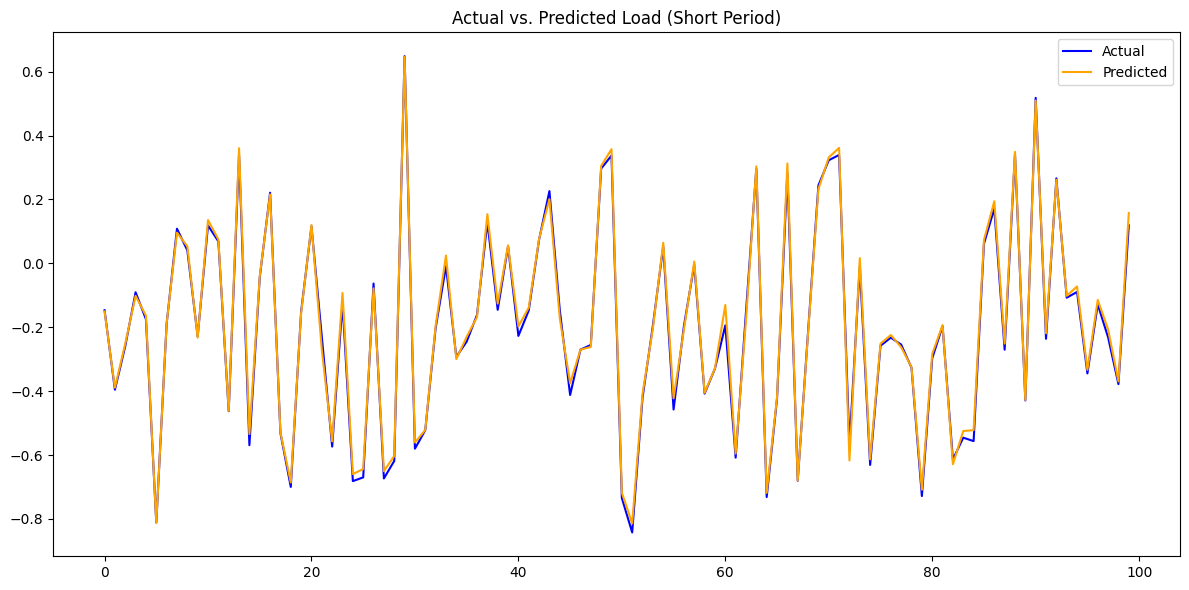

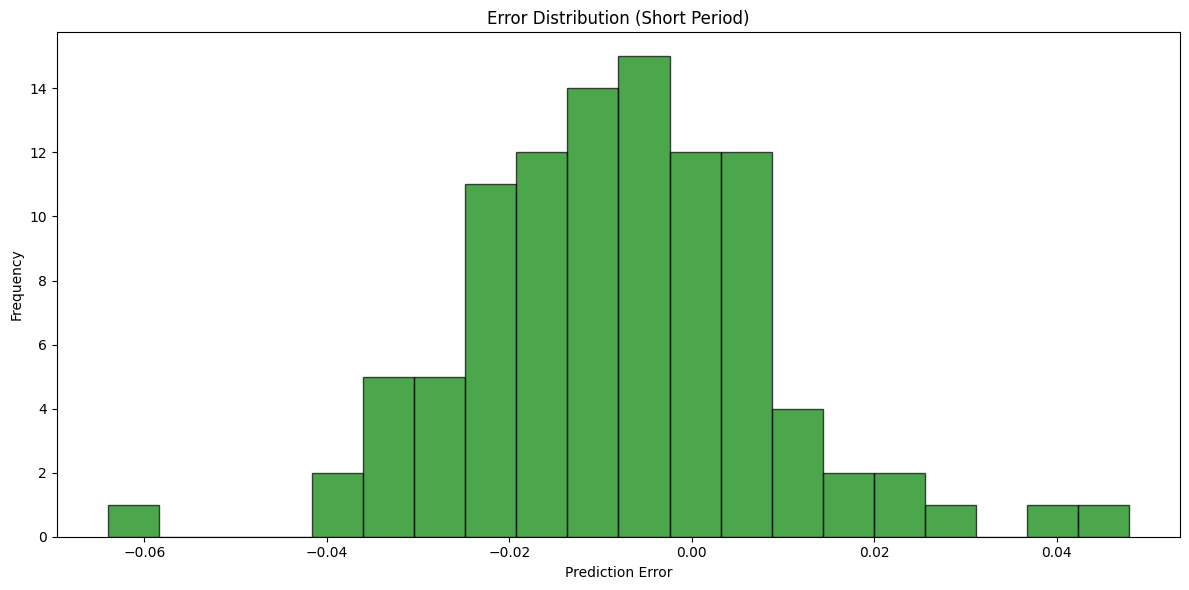

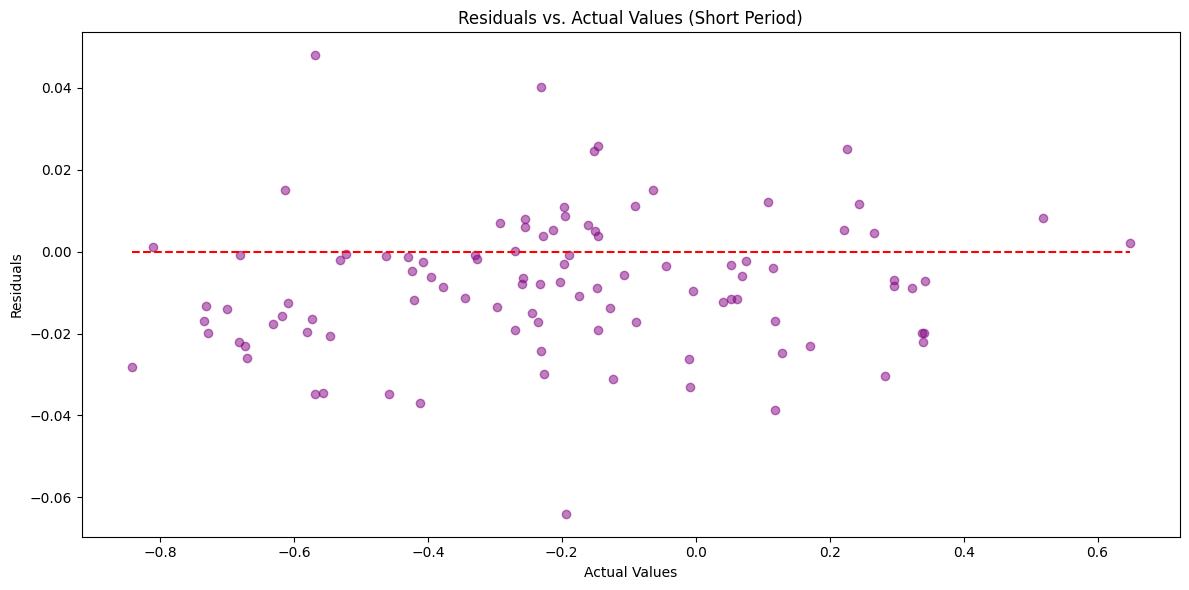

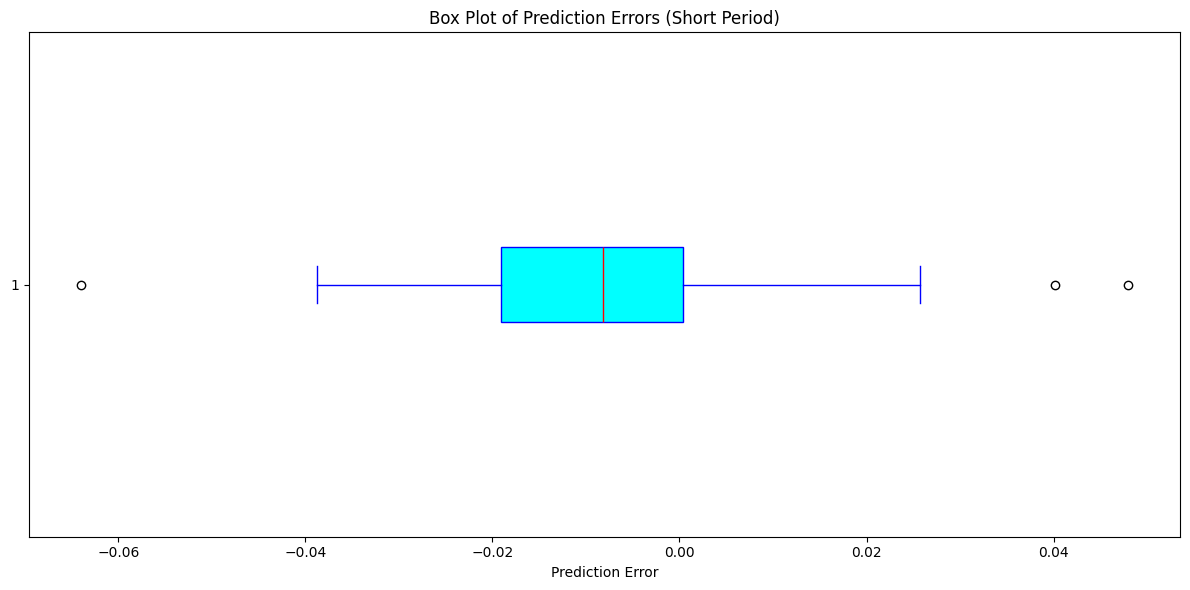

In [10]:
import matplotlib.pyplot as plt

# Define the path to save the figures
save_path = '/Users/shayan/Documents/My Research/CEEMDAN-TCN-AutoLSTM/data/'

# Define a short period for visualization
short_period = 100

# Line Graph of Actual vs. Predicted values for short period of test set
plt.figure(figsize=(12, 6))
plt.plot(y_test[:short_period], label='Actual', color='blue')
plt.plot(y_test_pred[:short_period], label='Predicted', color='orange')
plt.title('Actual vs. Predicted Load (Short Period)')
plt.legend()
plt.tight_layout()
plt.savefig(save_path + 'short_period_test_set_forecasted_patterns_lstm.png')
plt.show()

# Error Distribution Graph (Histogram of Errors) for short period
errors_short = y_test[:short_period] - y_test_pred[:short_period]
plt.figure(figsize=(12, 6))
plt.hist(errors_short, bins=20, edgecolor='k', alpha=0.7, color='green')
plt.title('Error Distribution (Short Period)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_path + 'short_period_error_distribution_lstm.png')
plt.show()

# Residual Plot for short period
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:short_period], errors_short, alpha=0.5, color='purple')
plt.hlines(y=0, xmin=min(y_test[:short_period]), xmax=max(y_test[:short_period]), colors='red', linestyles='dashed')
plt.title('Residuals vs. Actual Values (Short Period)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig(save_path + 'short_period_residuals_vs_actual_lstm.png')
plt.show()

# Box Plot of Errors for short period
plt.figure(figsize=(12, 6))
plt.boxplot(errors_short, vert=False, patch_artist=True,
            boxprops=dict(facecolor='cyan', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Prediction Errors (Short Period)')
plt.xlabel('Prediction Error')
plt.tight_layout()
plt.savefig(save_path + 'short_period_box_plot_errors_lstm.png')
plt.show()

Analysis of all the above graph individually

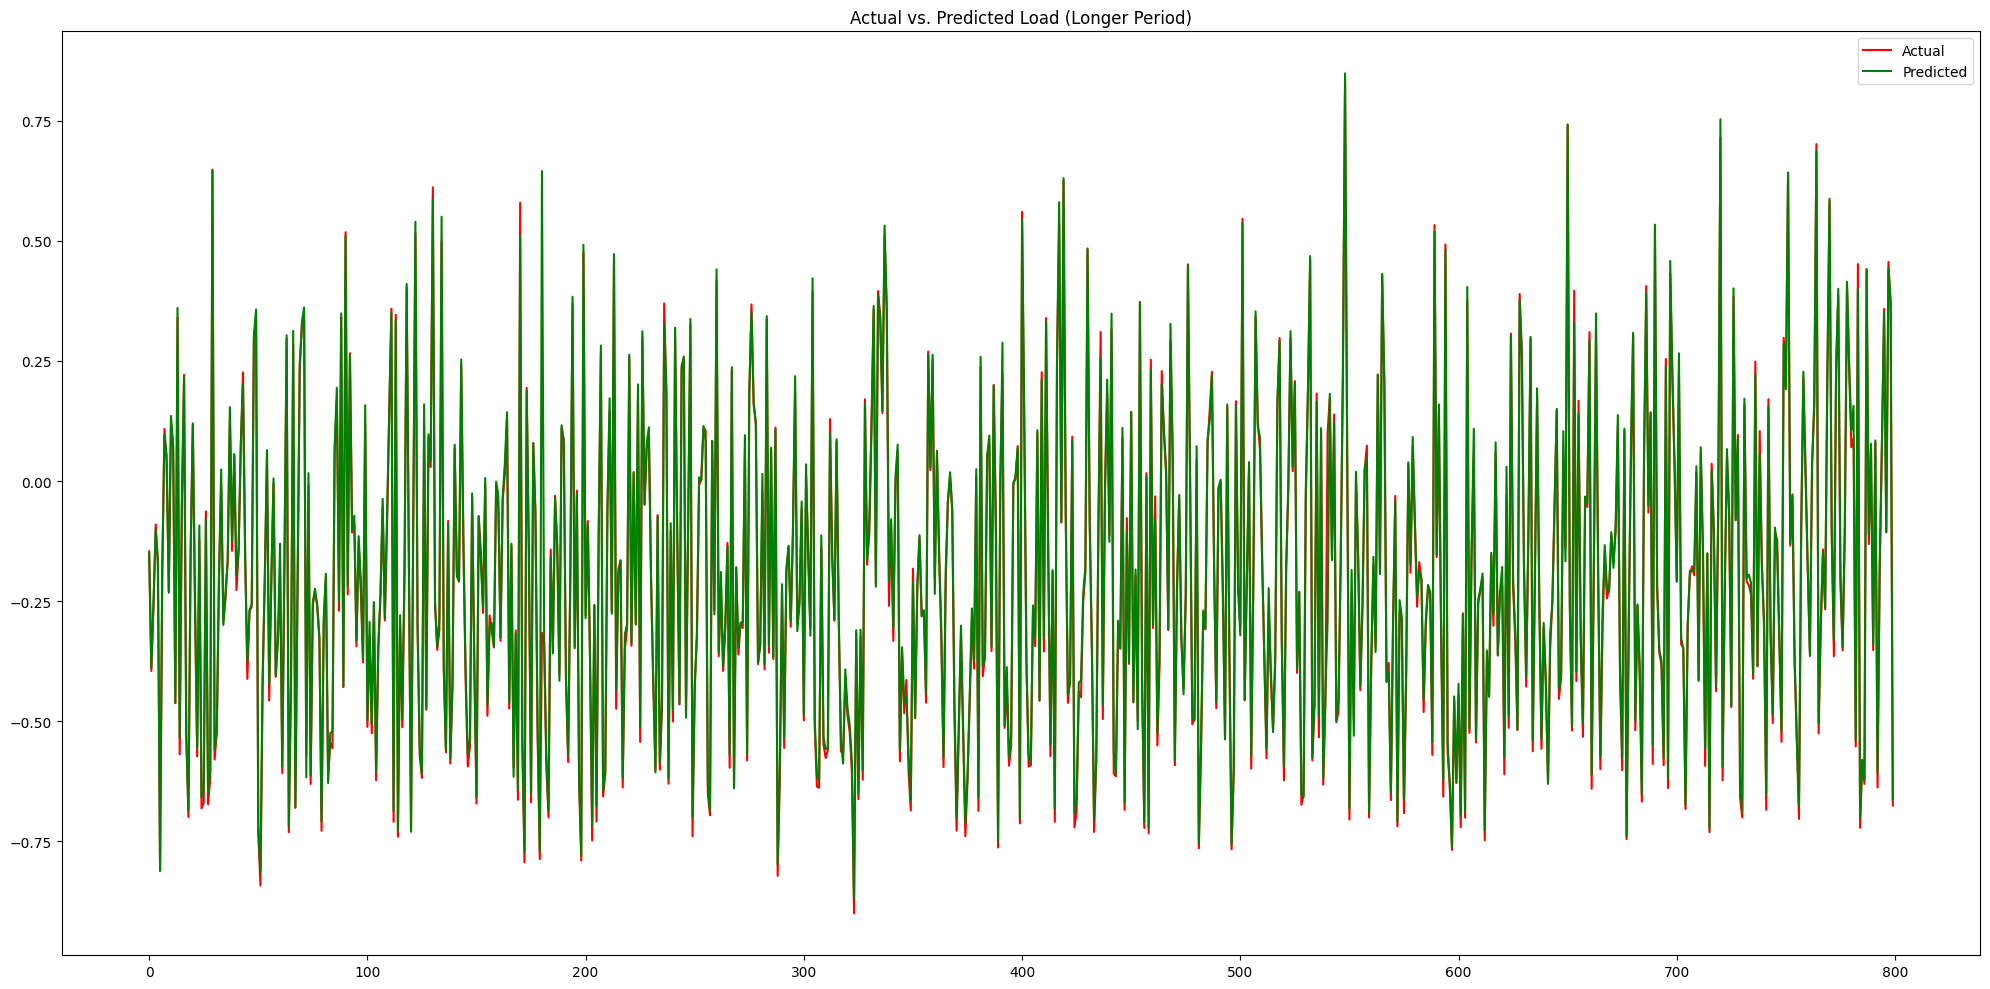

In [41]:
# Define a short period for visualization
short_period = 800

# Line Graph of Actual vs. Predicted values for short period of test set
plt.figure(figsize=(20, 10))
plt.plot(y_test[:short_period], label='Actual', color='red')
plt.plot(y_test_pred[:short_period], label='Predicted', color='green')
plt.title('Actual vs. Predicted Load (Longer Period)')
plt.legend()
plt.tight_layout()
plt.savefig(save_path + 'short_period_test_set_forecasted_patterns_lstm.png')
plt.show()

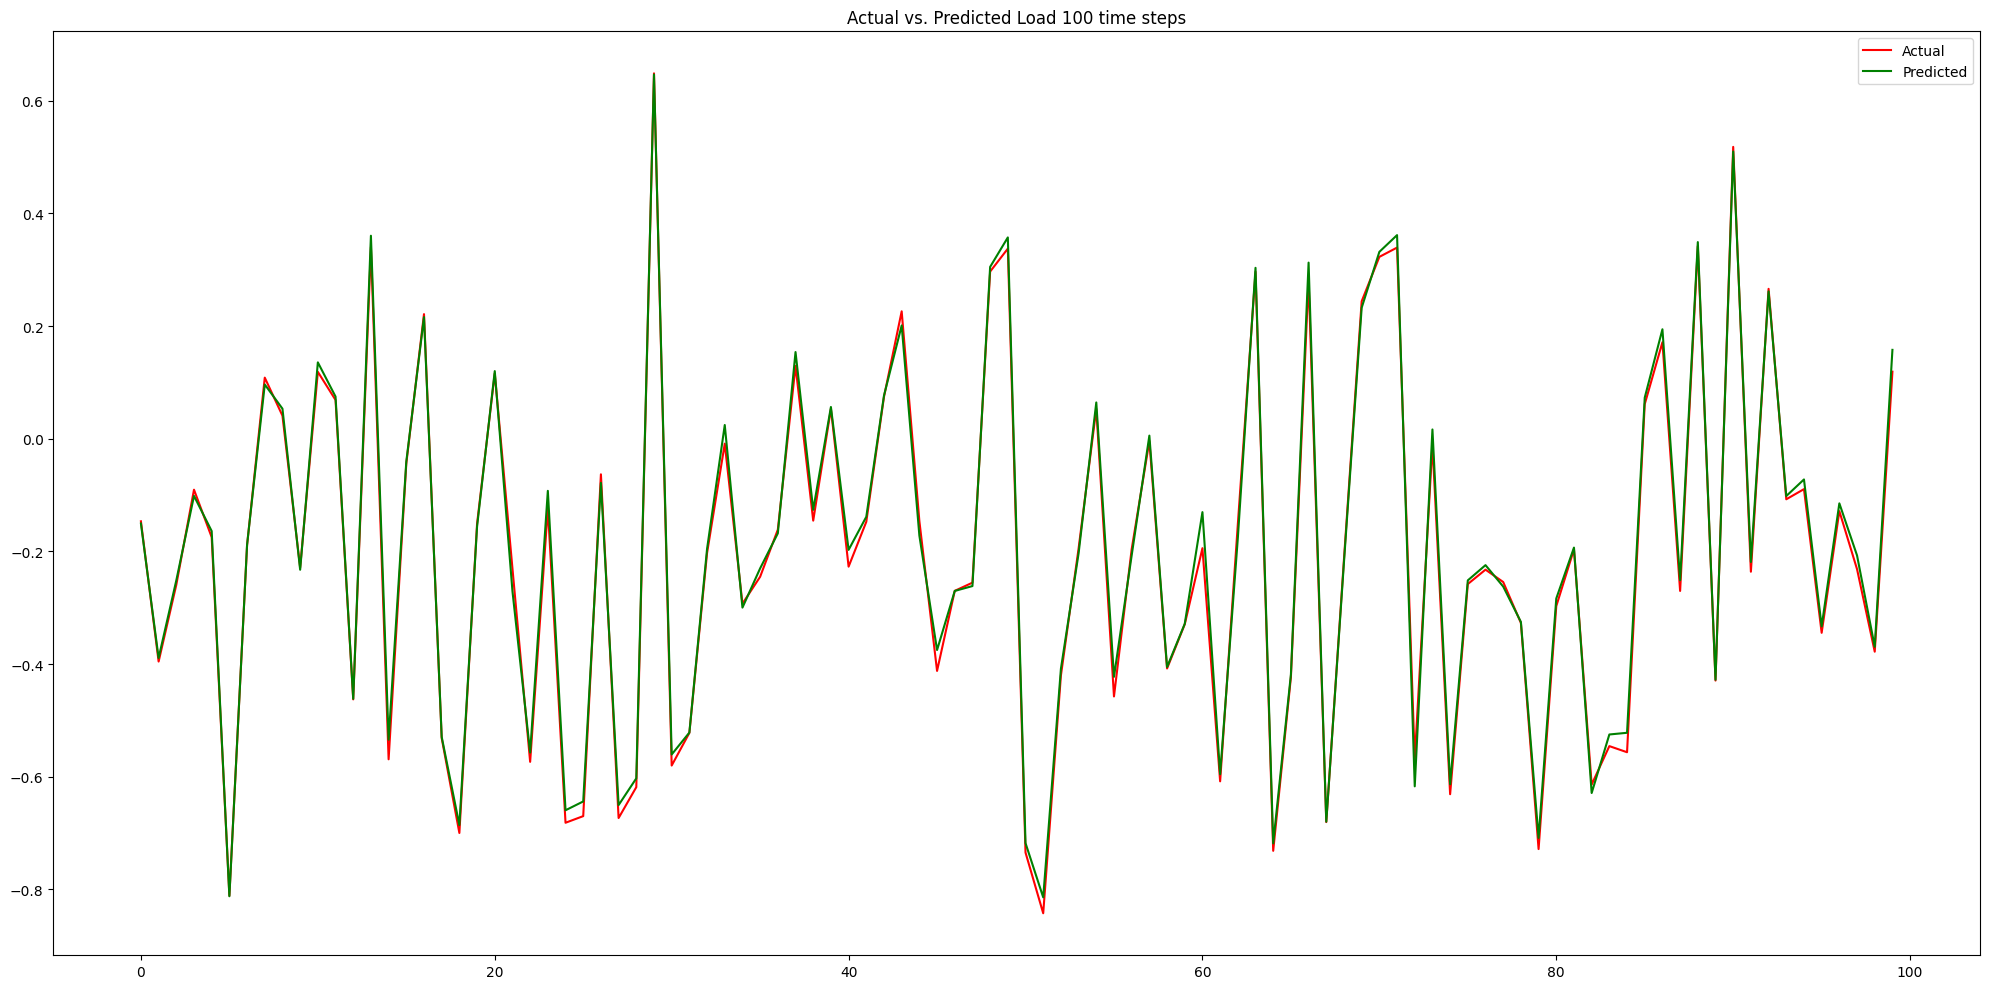

In [27]:
# Define a short period for visualization
short_period = 100

# Line Graph of Actual vs. Predicted values for short period of test set
plt.figure(figsize=(20, 10))
plt.plot(y_test[:short_period], label='Actual', color='red')
plt.plot(y_test_pred[:short_period], label='Predicted', color='green')
plt.title('Actual vs. Predicted Load 100 time steps')
plt.legend()
plt.tight_layout()
plt.savefig(save_path + '100cshort_period_test_set_forecasted_patterns_lstm.png')
plt.show()

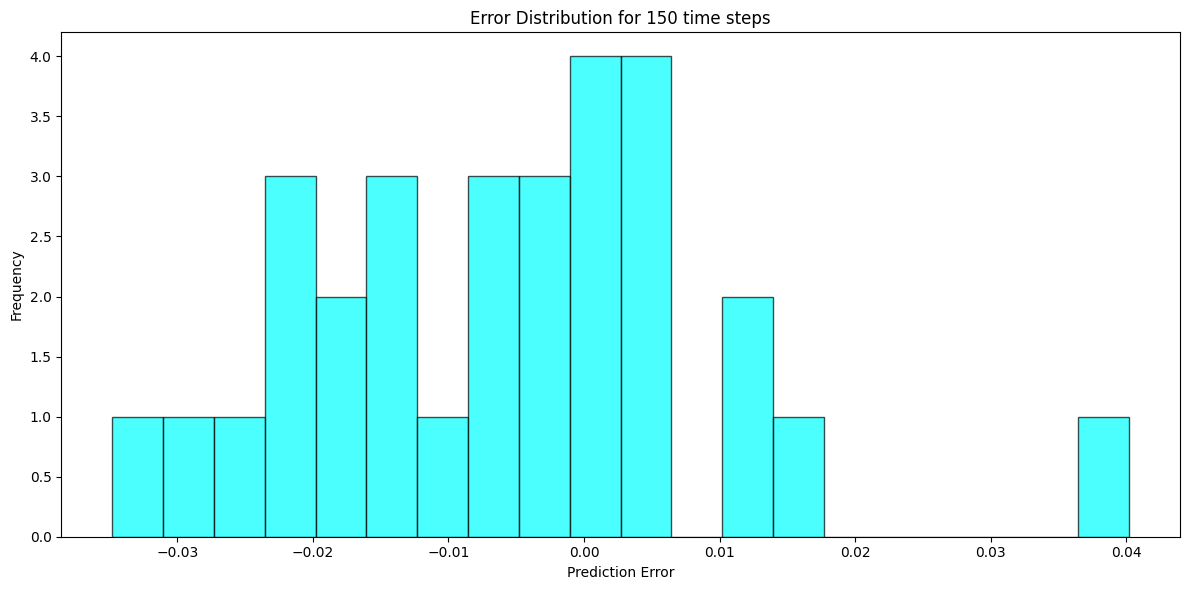

In [46]:
# Define a short period for visualization
short_period = 30

# Error Distribution Graph (Histogram of Errors) for short period
errors_short = y_test[:short_period] - y_test_pred[:short_period]
plt.figure(figsize=(12, 6))
plt.hist(errors_short, bins=20, edgecolor='k', alpha=0.7, color='cyan')
plt.title('Error Distribution for 150 time steps')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(save_path + 'new short_period_error_distribution_lstm.png')
plt.show()

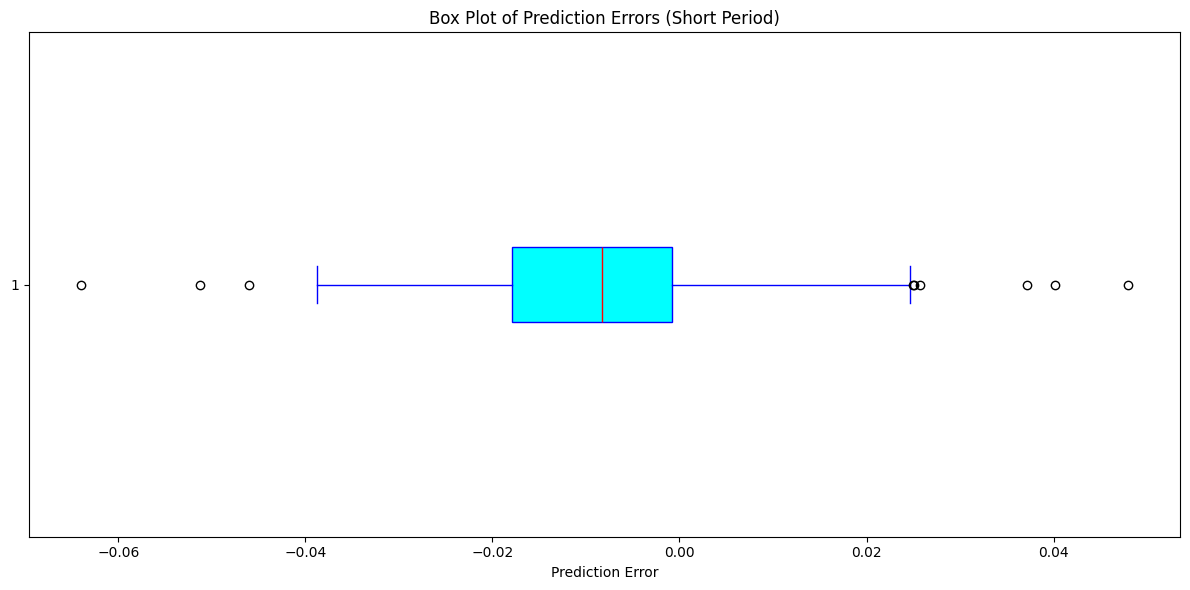

In [38]:
short_period = 350

# Box Plot of Errors for short period
plt.figure(figsize=(12, 6))
plt.boxplot(errors_short, vert=False, patch_artist=True,
            boxprops=dict(facecolor='cyan', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Prediction Errors (Short Period)')
plt.xlabel('Prediction Error')
plt.tight_layout()
plt.savefig(save_path + 'short_period_box_plot_errors_lstm.png')
plt.show()